In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202107'))

CONNECT_ROBOT = False
CONNECT_MOBILE = False
USE_SDK = False

MOBILE_IP = "192.168.17.2"
ROBOT_IP = "192.168.17.2"
IP_CUR = "192.168.17.2" # get_ip_address()

print("Mobile IP: {}".format(MOBILE_IP))
print("ROBOT  IP: {}".format(ROBOT_IP))

In [2]:
from enum import Enum
class ExpType(Enum):
    REMOVE_OBS=0   # 5 constrained obstacles, 5 target points
    CONTACT_TAR=1  # 3 big/small/constrained obstacles, 5 target areas

EXP_SCENARIO = ExpType.CONTACT_TAR

In [3]:
# ROBOT_BASE_OFFSET = (0,0,0.592)
# ROBOT_BASE_RPY = (0,0,0)

ROBOT_BASE_OFFSET = (0.2,0,0.522)
ROBOT_BASE_RPY = (0,0,0)

TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001
WS_HEIGHT = 1.7
COL_COLOR = (1,1,1,0.2)
    
if EXP_SCENARIO == ExpType.REMOVE_OBS: ## Obstacle removing
    BAG_COUNT = 0
    CLOCK_COUNT = 0
    DOOR_COUNT = 5
    TARGET_COUNT = 5
    LOG_FORCE = False
else: ## Contact 
    BAG_COUNT = 3
    CLOCK_COUNT = 3
    DOOR_COUNT = 3
    TARGET_COUNT = 5
    LOG_FORCE = True

from pkg.controller.combined_robot import *
from pkg.project_config import *

In [4]:


if not CONNECT_ROBOT:
    indy_7dof_client.kiro_tool.OFFLINE_MODE = True
kiro_udp_client.KIRO_UDP_OFFLINE_DEBUG = not CONNECT_MOBILE

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                "{}/{}".format(MOBILE_IP, IP_CUR))
# robot_config = RobotConfig(1, RobotType.indy7kiro, 
robot_config = RobotConfig(1, RobotType.panda_arm, 
                           (ROBOT_BASE_OFFSET, ROBOT_BASE_RPY),
                INDY_IP, root_on="kmb0_platform", 
                           specs={"no_sdk":True} if not USE_SDK else {})

ROBOT_TYPE = robot_config.type
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()

ROBOT_TYPE = robot_config.type
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config], 
                     connection_list=[CONNECT_MOBILE, CONNECT_ROBOT])

connection command:
kmb0: False
panda_arm1: False


### Make scene

In [5]:
from pkg.geometry.builder.scene_builder import SceneBuilder
from pkg.planning.scene import PlanningScene

s_builder = SceneBuilder(None)
gscene = s_builder.create_gscene(crob)
gtems = s_builder.add_robot_geometries(
    color=COL_COLOR, display=True, collision=True)

gscene.set_workspace_boundary(
    -4, 6, -2.5, 2.5, -CLEARANCE, WS_HEIGHT, thickness=WALL_THICKNESS)

crob.home_pose = np.array([-2.5 ,   0. ,   0. ,   0. ,   0. ,   0. ]   
                  + np.deg2rad([0. , -60,   0. , -90. ,   0. ,  90. ,  90]).tolist())
crob.home_dict = list2dict(item_names=crob.joint_names, item_list=crob.home_pose)
gscene.show_pose(crob.home_pose)

Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


### Planning scene

In [6]:
from pkg.geometry.geometry import *
from pkg.utils.code_scraps import *
from pkg.planning.constraint.constraint_subject import *
from pkg.planning.constraint.constraint_actor import *
from exp_config import *

pscene = PlanningScene(gscene, combined_robot=crob)

In [7]:
from demo_utils.environment import *

In [8]:
ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE
BRUSH_NAME = "brush_face"


theta = -np.pi*4/4
add_panda_cam(gscene, tool_link=TIP_LINK, theta=theta)
brush_face = add_panda_brush(gscene, tool_link=TIP_LINK, theta=theta, brush_name=BRUSH_NAME)

# TOOL_DIM = [0.14, 0.30]
# TOOL_CENTER_OFF = [0, -0.035, 0]
# TOOL_THICKNESS = 0.08
# brush_face = add_brush(gscene, face_name=TOOL_NAME, tool_link=TIP_LINK,
#                        thickness=TOOL_THICKNESS, tool_dim=TOOL_DIM,
#                        col_color=COL_COLOR, center_off=TOOL_CENTER_OFF)

point_brush, rpy_brush = (0,0,-brush_face.dims[2]/2), (0,0,0)
brush_b = pscene.create_binder(BRUSH_NAME, BRUSH_NAME, WayFramer, point=point_brush, rpy=rpy_brush)
gscene.show_pose(crob.home_pose)

MOBILE_PUSH_NAME = "mpush"
MOBILE_PUSH_HEIGHT = 0.4
MOBILE_PUSH_KEY = 1
MOBILE_SLIDE_KEY = 2
front_dist = 0.51
mpush_g = gscene.create_safe(GEOTYPE.SPHERE, MOBILE_PUSH_NAME, link_name=HOLD_LINK,dims=(0.01,0.01,0.01),
                           center=(front_dist, 0, MOBILE_PUSH_HEIGHT), rpy=(0,np.pi/2,0),
                           fixed=True, collision=False, color=(1,0,0,0.5))
mpush_b = pscene.create_binder(MOBILE_PUSH_NAME, MOBILE_PUSH_NAME, FramedTool, point=(0,0,0), rpy=(0,0,0), key=MOBILE_PUSH_KEY)

floor_b = pscene.create_binder("floor_ws", "floor_ws", PlaceFrame, point=(0,0,WALL_THICKNESS/2), key=MOBILE_SLIDE_KEY)

TOOL_PUSH_NAME = "tpush"
TOOL_PUSH_HEIGHT = 0.08
TOOL_PUSH_KEY = 10
TOOL_SLIDE_KEY = 11
brush_col = gscene.NAME_DICT[BRUSH_NAME+"_col"]
TOOL_DIM = brush_col.dims

center_push, rpy_push = (TOOL_DIM[0]/2+CLEARANCE, 0, 0), (0,np.pi/2,0)    
tpush_g = gscene.create_safe(GEOTYPE.SPHERE, TOOL_PUSH_NAME, link_name=TIP_LINK,dims=(0.01,0.01,0.01),
                           center=center_push, rpy=rpy_push,
                           fixed=True, collision=False, color=(1,0,0,0.5), parent=BRUSH_NAME)
tpush_b = pscene.create_binder(TOOL_PUSH_NAME, TOOL_PUSH_NAME, FramedTool, point=(0,0,0), rpy=(0,0,0), key=TOOL_PUSH_KEY)


DOOR_PUSH_NAME = "dpush"
DOOR_PUSH_HEIGHT = 0.08
DOOR_PUSH_KEY = 20
DOOR_SLIDE_KEY = 21
center_push, rpy_push = (0, -TOOL_DIM[1]/2-CLEARANCE, 0), (0,0,0)    
dpush_g = gscene.create_safe(GEOTYPE.SPHERE, DOOR_PUSH_NAME, link_name=TIP_LINK,dims=(0.01,0.01,0.01),
                           center=center_push, rpy=rpy_push,
                           fixed=True, collision=False, color=(1,0,0,0.5), parent=BRUSH_NAME)
dpush_b = pscene.create_binder(DOOR_PUSH_NAME, DOOR_PUSH_NAME, FramedTool, point=(0,0,0), rpy=(0,0,0), key=DOOR_PUSH_KEY)

## Table

In [9]:
TABLE_DIM = (0.6, 1.2, 0.7)
TABLE_NAME = "table"
TABLE_LOC = (5, 0, TABLE_DIM[2]/2)
TABLE_RPY = (0,0,0)

In [10]:
table_g = gscene.create_safe(GEOTYPE.BOX, TABLE_NAME, link_name="base_link", dims=TABLE_DIM,
                             center=TABLE_LOC, rpy=TABLE_RPY,
                             fixed=True, collision=True, color=(0.8,0.8,0.8,1))
table_b = pscene.create_binder(TABLE_NAME, TABLE_NAME, PlaceFrame, point=(0,0,TABLE_DIM[2]/2), key=TOOL_SLIDE_KEY)
gscene.add_virtual_guardrail(table_g, HEIGHT=0.01, axis="xy")

## Waypoints

In [11]:
WP_NAME = "wp_{}"
WP_DIM = (0.1,0.1,0.01)
WP_LOC = (-0.2, 0.0, TABLE_DIM[2]/2+WP_DIM[2]/2)
WP_RPY = (0,0,0)

In [12]:
wp_g_list = []
for i_t in range(TARGET_COUNT):
    wp_g = gscene.create_safe(GEOTYPE.BOX, WP_NAME.format(i_t), link_name="base_link", dims=WP_DIM,
                              center=(WP_LOC[0], WP_LOC[1]-0.4+i_t*0.2, WP_LOC[2]), rpy=WP_RPY,
                              fixed=True, collision=True, color=(0.0,0.0,0.8,1), parent=TABLE_NAME)
    wp_g_list.append(wp_g)
waypoint_s = pscene.create_subject(oname="waypoints", gname=TABLE_NAME, _type=WaypointTask,
                                 action_points_dict={
                                     wp_g.name: WayFrame(
                                         wp_g.name, wp_g, [0, 0, wp_g.dims[2] / 2], [0, 0, 0])
                                     for wp_g in wp_g_list
                                 })

## Clock

In [13]:
CLOCK_NAME = "clock_{}"
CLOCK_DIM = (0.14,0.05,0.076)
clock_center = np.add(wp_g.center[:2]+(0,), (0,0.1,TABLE_DIM[2]+CLOCK_DIM[2]/2+CLEARANCE))

In [14]:
for i_c in range(CLOCK_COUNT):
    CLOCK_NAME_I = CLOCK_NAME.format(i_c)
    clock_g = gscene.create_safe(GEOTYPE.BOX, CLOCK_NAME_I, link_name="base_link",dims=CLOCK_DIM,
                               center=(clock_center[0], clock_center[1]-i_c*0.4, clock_center[2]), rpy=(0,0,0),
                               fixed=False, collision=True, color=(0.8,0.5,0.3,1))

    push_point_list = []
    for i in range(1):
        R = Rot_axis_series([3, 2], [np.pi/2*i, np.pi/2])
        point = np.round(np.multiply(CLOCK_DIM, -R[:,2])/2, 4)
        point[2] = -CLOCK_DIM[2]/2 + TOOL_PUSH_HEIGHT
        ap_name = "side{}".format(i)
        push_point_list.append(FramePoint(ap_name, clock_g, point=point, rpy=Rot2rpy(R), key=TOOL_PUSH_KEY))

    dir_push = [0,0,1]
    slide_point = SlidePoint("bottom_p", clock_g, point=(0,0,-CLOCK_DIM[2]/2-CLEARANCE), rpy=(0,0,0), 
                             binded_on=table_b, dist_push_min=0.1, dist_push_max=0.3, dir_push=dir_push, key=TOOL_SLIDE_KEY)

    clock_s = pscene.create_subject(oname=CLOCK_NAME_I, gname=CLOCK_NAME_I, _type=PushObject, 
                                  push_point_list=push_point_list, slide_point=slide_point)

## Bag

In [15]:
BAG_NAME = "bag_{}"
BAG_DIM = (0.4, 0.29,0.64)

In [16]:
for i_b in range(BAG_COUNT):
    BAG_NAME_I = BAG_NAME.format(i_b)
    bag_center = [2.5,0.8*(i_b-int(BAG_COUNT/2)),BAG_DIM[2]/2]
    if EXP_SCENARIO == ExpType.CONTACT_TAR:
        bag_center[1] *= 1.7
    bag_g = gscene.create_safe(GEOTYPE.BOX, BAG_NAME_I, link_name="base_link",dims=BAG_DIM,
                               center=bag_center, rpy=(0,0,0),
                               fixed=False, collision=True, color=(0.8,0.8,0.8,1))
    handle = gscene.create_safe(GEOTYPE.BOX, BAG_NAME_I+"_hdl", link_name="base_link",dims=(0.2,0.03,0.02),
                               center=(0,0,BAG_DIM[2]/2+0.01), rpy=(0,0,0),
                               fixed=False, collision=True, color=(0.6,0.6,0.6,1), parent=BAG_NAME_I)

    push_point_list = []
    for i in range(4):
        R = Rot_axis_series([3, 2], [np.pi/2*i, np.pi/2])
        point = np.round(np.multiply(BAG_DIM, -R[:,2])/2, 4)
        point[2] = -BAG_DIM[2]/2 + MOBILE_PUSH_HEIGHT
        ap_name = "side{}".format(i)
        push_point_list.append(FramePoint(ap_name, bag_g, point=point, rpy=Rot2rpy(R), key=MOBILE_PUSH_KEY))

    slide_point = SlidePoint("bottom_p", bag_g, point=(0,0,-BAG_DIM[2]/2-CLEARANCE), rpy=(0,0,0), 
                                               binded_on=floor_b, dist_push_min=0.1, dist_push_max=1.0, key=MOBILE_SLIDE_KEY)

    bag_s = pscene.create_subject(oname=BAG_NAME_I, gname=BAG_NAME_I, _type=PushObject, 
                                  push_point_list=push_point_list, slide_point=slide_point)

## Door

In [17]:
DOOR_CLEARANCE_ADD = CLEARANCE*4
DOOR_DIM = (0.05,1.1,1.5)
DOOR_POS = (0,1,DOOR_DIM[2]/2+DOOR_CLEARANCE_ADD)
DOOR_NAME = "door_slide"

In [18]:
door_g = gscene.create_safe(GEOTYPE.BOX, DOOR_NAME, link_name="base_link",dims=DOOR_DIM,
                            center=DOOR_POS, rpy=(0,0,0),
                            fixed=False, collision=True, color=(0.8,0.5,0.3,1))

In [19]:
doorknob_g = gscene.create_safe(GEOTYPE.BOX, DOOR_NAME+"_knob", link_name="base_link",
                                dims=(0.05,0.05,0.2), center=(-0.05,DOOR_DIM[1]/2-0.05,0), rpy=(0,0,0),
                                fixed=False, collision=True, color=(0.8,0.5,0.3,1),
                                parent=DOOR_NAME)

In [20]:
push_point_list = []
R = np.identity(3)
point = np.add(doorknob_g.center_child, [-TOOL_DIM[0]/2, doorknob_g.dims[1]/2, 0])
ap_name = "knob_p"
push_point_list.append(FramePoint(ap_name, door_g, point=point, rpy=Rot2rpy(R), key=DOOR_PUSH_KEY))

dir_push = [1,0,0]
slide_point = SlidePoint("bottom_p", door_g, point=(0,0,-DOOR_DIM[2]/2-CLEARANCE-DOOR_CLEARANCE_ADD), rpy=(0,0,0), 
                         binded_on=floor_b, dist_push_min=0.2, dist_push_max=1, dir_push=dir_push, key=MOBILE_SLIDE_KEY)

door_s = pscene.create_subject(oname=DOOR_NAME, gname=DOOR_NAME, _type=PushObject, 
                               push_point_list=push_point_list, slide_point=slide_point)

In [21]:
verts = door_g.get_vertice_radius_from("base_link")[0]
verts_max = np.max(verts, axis=0)
verts_min = np.min(verts, axis=0)
wall_1_width = abs(-2.5-verts_min[1])
wall_1_center = (-2.5+verts_min[1])/2

wall_1 = gscene.create_safe(GEOTYPE.BOX, "wall_1", link_name="base_link",
                            dims=(DOOR_DIM[0], wall_1_width, DOOR_DIM[2]),
                            center=(verts_max[0]+DOOR_DIM[0]/2+CLEARANCE+DOOR_CLEARANCE_ADD,
                                    wall_1_center,DOOR_DIM[2]/2), rpy=(0,0,0),
                            fixed=False, collision=True, color=(0.8,0.5,0.3,1))


wall_2_width = abs(2.5-verts_max[1])
wall_2_center = (2.5+verts_max[1])/2

wall_2 = gscene.create_safe(GEOTYPE.BOX, "wall_2", link_name="base_link",
                            dims=(DOOR_DIM[0], wall_2_width, DOOR_DIM[2]),
                            center=(verts_max[0]+DOOR_DIM[0]/2+CLEARANCE+DOOR_CLEARANCE_ADD,
                                    wall_2_center,DOOR_DIM[2]/2), rpy=(0,0,0),
                            fixed=False, collision=True, color=(0.8,0.5,0.3,1))

### prepare planner

In [22]:
from pkg.planning.filtering.grasp_filter import GraspChecker
from pkg.planning.filtering.reach_filter import ReachChecker
gcheck = GraspChecker(pscene)
rcheck = ReachChecker(pscene)

from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene, enable_dual=False)
mplan.update_gscene()
mplan.incremental_constraint_motion = True
# mplan.visualize_increments = True

from pkg.planning.incremental_search import *
# joint motion is not allowed when pusing object with holder
idc_push = np.where([stype == PushObject for stype in pscene.subject_type_list])[0]
inc = IncrementalSearch(pscene, gcheck, rcheck, 
                        explicit_rule= lambda pscene, node, leaf: not any([node[idx]==leaf[idx] and "push" in node[idx] for idx in idc_push]))
inc.prepare()
inc.set_motion_planner(mplan)
inc.prepare()

cresv = CollisionResolver(inc, gcheck)
rresv = ReachResolver(inc, rcheck, mplan, floor=floor_b.geometry)
mresv = MotionResolver(inc, mplan)
inc.resolver_stack = [cresv, rresv, mresv]

from pkg.ui.ui_broker import *
# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(inc, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

[WARN] reach data is not ready for kmb. Ignoring this robot...
Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production


### Plan

In [23]:
gscene.show_pose(crob.home_pose)
chain_list = \
    [BindingChain(BAG_NAME.format(i_b), "bottom_p", "floor_ws", "floor_ws") for i_b in range(BAG_COUNT)] \
    + [BindingChain(CLOCK_NAME.format(i_c), "bottom_p", "table", "table") for i_b in range(CLOCK_COUNT)] \
    + [BindingChain(DOOR_NAME, "bottom_p", "floor_ws", "floor_ws")] \
    + [BindingChain("waypoints", None, None, None)]
initial_state = pscene.initialize_state(crob.home_pose, chain_list=chain_list)
gscene.update_markers_all()
print(pscene.subject_name_list)
print(initial_state.node)

   Use a production WSGI server instead.
 * Debug mode: off
['bag_0', 'bag_1', 'bag_2', 'clock_0', 'clock_1', 'clock_2', 'door_slide', 'waypoints']
('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)


## DEV planner

In [24]:
last_state = initial_state.copy(pscene)
snode_schedule_all = []
N_GOAL = 5
for i in range(N_GOAL):
    from_state = last_state.copy(pscene)
    goal_nodes = [from_state.node[:-1]+(i+1,)]

    inc.search(from_state, goal_nodes, max_solution_count=1,
               verbose=True, display=False, dt_vis=0.01, 
               timeout=2.0, timeout_loop=300, 
               multiprocess=True, add_homing=(i==N_GOAL-1))

    snode_schedule = inc.get_best_schedule(at_home=False)
    if i==N_GOAL-1:
        snode_schedule += inc.add_return_motion(snode_schedule[-1], initial_state=initial_state)
    else:
        home_tmp = snode_schedule[-1].state.copy(pscene)
        home_tmp.Q[crob.idx_dict[ROBOT_NAME]] = initial_state.Q[crob.idx_dict[ROBOT_NAME]]
        snode_schedule += inc.add_return_motion(snode_schedule[-1], initial_state=home_tmp, timeout=2, try_count=10)
        
    snode_schedule_all += snode_schedule
    last_state = snode_schedule[-1].state.copy(pscene)

Use 10/20 agents
[WARN] Transition Queue Empty
resolve reach from [-2.5   0.    0.    0.    0.    0.    0.   -1.05  0.   -1.57  0.    1.57
  1.57]
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
[WARN] Transition Queue Empty
error: 6.9
try joint motion
try transition motion
joint motion tried: True
try joint motion
transition motion tried: False
[WARN] Transition Queue Empty
resolve reach from [-2.5   0.    0.    0.    0.    0.    0.   -1.05  0.   -1.57  0.    1.57
  1.57]
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
[WARN] Transition Queue Empty
error: 6.9
try joint motion
try transition motion
joint motion tried: True
try joint motion
joint motion tried: False
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
error: 5.4
try transition motion
resolve reach from [-2.5   0.    0.    0.    0.    0.    0.   -1.05  0.   -1.57  0.    1.57
  1.57]
move base ('floor_ws', 'floor_ws', 'floor_ws', 'tab

joint min [4] ([ -35   83 -121    0    0    0   68  -50   69 -128 -157  168  -65])
constrained motion tried: False
error: 0.4
joint min [6] ([ -35   83 -121    0    0    0 -112  -42  -74 -133 -139  101 -157])
constrained motion tried: False
try joint motion
error: 0.95
error: 0.68
joint min [6] ([ -35   83 -121    0    0    0 -130  -46  -66 -141 -142  108 -157])
constrained motion tried: False
error: 0.81
joint min [6] ([ -35   83 -121    0    0    0 -130  -46  -66 -141 -142  108 -157])
constrained motion tried: False
joint min [0] ([ -35   83 -121    0    0    0 -158  -47  -58 -147 -148  126 -153])
constrained motion tried: False
error: 0.3
error: 0.66
joint min [6] ([ -35   83 -121    0    0    0 -128  -45  -66 -140 -141  107 -157])
constrained motion tried: False
transition motion tried: True
joint min [4] ([ -35   83 -121    0    0    0   68  -50   69 -128 -157  167  -65])
constrained motion tried: False
error: 0.25
error: 0.37
joint min [4] ([ -35   83 -121    0    0    0    8   5

error: 6.4
try transition motion
error: 2.7
try transition motion
transition motion tried: True
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -158  142 -145])
constrained motion tried: False
joint motion tried: True
try joint motion
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constrained motion tried: False
try joint motion
joint motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
error: 0.25
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.65
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 2.6
try transition motion
joint min [0 6] ([ -35   83 -121    0    0    0 -158  -53  -60 -148 -150  126 -157])
constrained motion tr

constrained motion tried: False
error: 0.33
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constrained motion tried: False
error: 5.4
try transition motion
joint motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error: 4.6
try transition motion
transition motion tried: False
transition motion tried: True
error: 0.57
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -158  141 -145])
constrained motion tried: False
error: 5.4
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.62  1.45 -2.12  0. 

link transfer between same links: ['door_slide'] - panda_arm1
transition motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.25
error: 0.73
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -158  141 -145])
constrained motion tried: False
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -158  141 -145])
constrained motion tried: False
error: 1.2
try transition motion
error: 0.43
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -158  141 -145])
constrained motion tried: False
error: 

constrained motion tried: False
resolve reach from [-0.62  1.45 -2.12  0.    0.    0.    0.16  0.73  2.22 -2.56 -2.65  2.36
 -2.53]
error: 0.87
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -158  141 -145])
constrained motion tried: False
joint min [4] ([ -35   83 -121    0    0    0    7   51  120 -146 -157  140 -151])
constrained motion tried: False
error: 0.43
resolve reach from [-0.62  1.45 -2.12  0.    0.    0.    0.28  0.79  2.16 -2.57 -2.62  2.28
 -2.63]
error: 0.94
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -158  141 -145])
constrained motion tried: False
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constrained motion tried: False
error: 0.73
error: 0.4
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constrained motion tried: False
error: 0.6
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -158  141 -145])
constrained motion tried: False
resolve 

error: 4.1
try transition motion
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.67
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.62  1.45 -2.12  0.    0.    0.    0.14  0.91  2.09 -2.56 -2.75  2.44
 -2.66]
error: 0.99
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constrained motion tried: False
resolve reach from [-0.62  1.45 -2.12  0.    0.    0.    0.14  0.91  2.09 -2.56 -2.75  2.44
 -2.66]
error: 0.78
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constrained motion tried: False
error: 0.43
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -15

error: 1.2
try transition motion
error: 2.6
try transition motion
transition motion tried: True
transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
resolve reach from [-1.2   1.41  0.29  0.    0.    0.    0.13  0.51 -0.3  -1.37 -2.63  2.84
 -1.92]
error: 0.98
error: 3.7
try transition motion
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.86
joint min [4] ([ -68   80   16    0    0    0    3   27  -15  -79 -158  163 -103])
transition motion tried: False
constrained motion tried: False
error: 0.56
error: 3.7
try transition motion
joint min 

joint min [6] ([ -47   73  -12    0    0    0  -36   44  113 -140 -133   88 -157])
constrained motion tried: False
try joint motion
try joint motion
joint motion tried: False
joint motion tried: True
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
try joint motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 2.6
try transition motion
joint motion tried: False
joint motion tried: False
try joint motion
try joint motion
joint motion tried: True
transition motion tried: True
joint motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floo

constrained motion tried: False
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  141 -152])
constrained motion tried: False
error: 0.36
error: 0.29
error: 0.77
resolve reach from [-0.62  1.45 -2.12  0.    0.    0.    0.16  0.73  2.22 -2.56 -2.65  2.36
 -2.53]
error: 0.91
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constrained motion tried: False
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -158  141 -145])
constrained motion tried: False
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -158  141 -145])
constrained motion tried: False
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constrained motion tried: False
resolve reach from [-1.2   1.41  0.29  0.    0.    0.    0.13  0.51 -0.3  -1.37 -2.63  2.84
 -1.92]
error: 0.5
error: 0.72
error: 0.77
error: 0.24
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -158  141 -145])
constrained mot

transition motion tried: True
error: 5.4
try transition motion
error: 5.4
try transition motion
transition motion tried: False
resolve reach from [-2.5   0.    0.    0.    0.    0.    0.   -1.05  0.   -1.57  0.    1.57
  1.57]
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 2.7
try transition motion
transition motion tried: False
error: 5.7
try transition motion
transition motion tried: False
error: 4.3
try transition motion
transition motion tried: False
error: 5.4
try transition motion
transition motion tried: False
transition motion tried: False
error: 3.3
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.45
joint min [4] ([ -35   83 -121    0    0    0    9   56  117 -147 -157  139 -157])
constrained motion tried: 

 -2.66]
error: 0.88
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constrained motion tried: False
error: 0.61
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constrained motion tried: False
error: 0.36
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constrained motion tried: False
error: 0.33
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
transition motion tried: True
error: 0.36
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constrained motion tried: False
error: 5.4
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'f

link transfer between same links: ['door_slide'] - panda_arm1
error: 0.88
joint min [4] ([ -35   83 -121    0    0    0  131  -23    0 -142 -159  149 -108])
constrained motion tried: False
transition motion tried: False
error: 0.8
transition motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.42
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -158  141 -145])
link transfer between same links: ['door_slide'] - panda_arm1
constrained motion tried: False
resolve reach from [-0.62  1.45 -2.12  0.    0.    0.    0.16  0.73  2.22 -2.56 -2.65  2.36
 -2.53]
error: 0.87
error: 4.3
tr

link transfer between same links: ['door_slide'] - panda_arm1
joint min [4] ([ -35   83 -121    0    0    0    7   51  120 -146 -157  140 -151])
constrained motion tried: False
resolve reach from [-0.62  1.45 -2.12  0.    0.    0.    0.33  0.73  2.18 -2.55 -2.57  2.24
 -2.6 ]
error: 0.93
error: 4.6
try transition motion
joint min [4] ([ -35   83 -121    0    0    0    7   51  120 -146 -157  140 -151])
constrained motion tried: False
joint min [4] ([ -35   83 -121    0    0    0    7   51  120 -146 -157  140 -151])
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error: 3.3
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dp

try transition motion
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
resolve reach from [-2.5   0.    0.    0.    0.    0.    0.   -1.05  0.   -1.57  0.    1.57
  1.57]
error: 2.7
try transition motion
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 2.7
try transition motion
collision
constrained motion tried: False
resolve reach from [-2.5   0.    0.    0.    0.    0.    0.   -1.05  0.   -1.57  0.    1.57
  1.57]
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 2.7
try transition motion
transition motion tried: False
resolve reach from [-2.5   0.    0.    0.    0.    0.    0.   -1.05  0.   -1.57  0.    1.57
  1.57]
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
reach not resolved
error: 2.7
try transition motion
transition motion tried: True
error: 4.9
try transition motion
transition motion tried: False
try 

constrained motion tried: False
resolve reach from [-0.77  1.7   2.85  0.    0.    0.   -0.51 -0.42 -2.42 -1.59  2.75  2.81
 -1.47]
error: 0.43
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.3
transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
joint min [2] ([ -44   97  163    0    0    0  -25  -70 -158  -18   65  144    3])
constrained motion tried: False
joint min [4] ([ -50   63   79    0    0    0   36    9 -106 -120 -159  152  -99])
constrained motion tried: False
resolve reach from [-0.64  1.76  1.61  0.    0.    0.    2.35 -1.02  1.2  -2.5   2.49  1.45
 -0.24]

constrained motion tried: False
joint min [4] ([ -68   80   16    0    0    0  -59   42   63  -85 -158  152 -147])
constrained motion tried: False
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constrained motion tried: False
error: 0.89
resolve reach from [-0.62  1.45 -2.12  0.    0.    0.    0.14  0.91  2.09 -2.56 -2.75  2.44
 -2.66]error: 0.31

error: 0.88
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constrained motion tried: False
constrained motion tried: False
error: 0.41
error: 0.46
joint min [4] ([ -35   83 -121    0    0    0    9   56  117 -146 -157  139 -157])
constrained motion tried: False
resolve reach from [-0.62  1.45 -2.12  0.    0.    0.    0.28  0.79  2.16 -2.57 -2.62  2.28
 -2.63]
error: 0.87
end
constrained motion tried: True
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -158  141 -145])
con

constrained motion tried: False
resolve reach from [-1.2   1.41  0.29  0.    0.    0.    2.19 -0.83 -1.95 -1.5  -2.68  2.51
 -2.75]
error: 0.86
error: 0.68
error: 0.27
joint min [4] ([ -35   83 -121    0    0    0    7   51  120 -146 -157  140 -151])
constrained motion tried: False
joint max [4] 
[ -68   80   16    0    0    0 -133  -73   93  -76  157  167    5]
[290 170  64  70   0  38 152]
constrained motion tried: False
error: 0.94
error: 0.24
joint min [6] ([ -47   73  -12    0    0    0  -36   44  113 -140 -133   88 -157])
constrained motion tried: False
error: 0.74
joint min [4] ([ -68   80   16    0    0    0  117  -47 -110  -86 -157  149 -154])
constrained motion tried: False
resolve reach from [-0.62  1.45 -2.12  0.    0.    0.    0.3   0.9   2.1  -2.58 -2.65  2.28
 -2.71]
error: 0.48
error: 1.0
joint min [4] ([ -35   83 -121    0    0    0    7   51  120 -146 -157  140 -151])
constrained motion tried: False
error: 0.71
joint min [4] ([ -35   83 -121    0    0    0    9   56  

joint min [4] ([ -35   83 -121    0    0    0    7   51  120 -146 -157  140 -151])
constrained motion tried: False
constrained motion tried: False
joint min [4] ([ -35   83 -121    0    0    0    7   51  120 -146 -157  140 -151])
constrained motion tried: False
error: 0.39
error: 0.52
error: 0.48
error: 0.6
joint min [4] ([ -68   80   16    0    0    0  150  -27 -156  -82 -158  158 -121])
constrained motion tried: False
error: 0.48
joint min [2] ([ -35   83 -121    0    0    0  -44    9 -157 -130 -123  134 -132])
constrained motion tried: False
error: 0.81
resolve reach from [-0.62  1.45 -2.12  0.    0.    0.    0.3   0.9   2.1  -2.58 -2.65  2.28
 -2.71]
joint motion tried: True
error: 0.97
joint min [4] ([ -35   83 -121    0    0    0    9   56  117 -147 -157  139 -157])
constrained motion tried: False
joint min [4] ([ -35   83 -121    0    0    0    9   56  117 -147 -157  139 -157])
constrained motion tried: False
resolve reach from [-0.64  1.76  1.61  0.    0.    0.    2.41 -0.88  1

error: 0.0023
error: 0.21
try transition motion
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -157  141 -145])
constrained motion tried: False
error: 0.29
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -157  141 -145])
constrained motion tried: False
transition motion tried: True
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -157  141 -145])
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -157  141 -145])
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.62 

error: 2.7
try transition motion
error: 5.4
try transition motion
resolve reach from [-2.5   0.    0.    0.    0.    0.    0.   -1.05  0.   -1.57  0.    1.57
  1.57]
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
joint motion tried: True
reach not resolved
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 2.7
try transition motion
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 2.7
try transition motion
error: 1.4
try transition motion
transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.31
end
constrained motion tried: True
transitio

transition motion tried: False
error: 0.21
transition motion tried: True
resolve reach from [-0.62  1.45 -2.12  0.    0.    0.    0.15  0.74  2.21 -2.56 -2.66  2.37
 -2.53]
error: 0.86
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -157  141 -145])
constrained motion tried: False
error: 0.28
error: 4.9
try transition motion
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -157  141 -145])
constrained motion tried: False
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -157  141 -145])
constrained motion tried: False
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.26 -0.72  0.18 -2.7  -2.72  2.71
 -1.84]
resolve reach from [-0.62  1.45 -2.12  0.    0.    0.    0.15  0.74  2.21 -2.56 -2.66  2.37
 -2.53]
error: 0.89
error: 0.97
joint min [4] ([ -47   73  -12    0    0    0   15  -41    8 -154 -158  155 -104])
constrained motion tried: False
resolve reach from [-0.92  1.84 -0.74  0.    0.    0.   -1.81 -1.21  1.4  -2.15  2.75 

error: 0.26
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -157  141 -145])
constrained motion tried: False
error: 0.37
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -157  141 -145])
constrained motion tried: False
resolve reach from [-0.92  1.84 -0.74  0.    0.    0.   -0.25  1.01 -0.12 -0.67  1.73  2.08
 -0.13]
error: 0.54
transition motion tried: True
transition motion tried: False
collision
constrained motion tried: False
error: 3.5
try transition motion
error: 0.21
resolve reach from [-2.5   0.    0.    0.    0.    0.    0.   -1.05  0.   -1.57  0.    1.57
  1.57]
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
transition motion tried: False
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -157  141 -145])
constrained motion tried: False
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 2.7
try transition motion
transition motion tried: Fals

link transfer between same links: ['door_slide'] - panda_arm1
error: 6.5
try transition motion
error: 2.7
try transition motion
transition motion tried: False
transition motion tried: True
joint motion tried: True
resolve reach from [-2.5   0.    0.    0.    0.    0.    0.   -1.05  0.   -1.57  0.    1.57
  1.57]
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 2.7
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
try joint motion
resolve reach from [-2.5   0.    0.    0.    0.    0.    0.   -1.05  0.   -1.57  0.    1.57
  1.57]
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
reach not resolved
error: 2.7
try transition motion
joint motion tried: False
transition motion tried: True
resolve

resolve reach from [-0.62  1.45 -2.12  0.    0.    0.    0.14  0.91  2.09 -2.56 -2.75  2.44
 -2.66]
joint motion tried: False
error: 0.98
error: 3.7
try transition motion
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constrained motion tried: False
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.51
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constrained motion tried: False
error: 0.24
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
error: 0.48
resolve reach from [-0.62  1.45 -2.12  0.    0.    0.    0.14  0.91  2.09 -2.56 -2.75  2.44
 -2.66]
error: 0.98
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constraine

transition motion tried: False
constrained motion tried: False
error: 0.63
joint min [4] ([ -35   83 -121    0    0    0    8   52  119 -146 -157  139 -152])
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
resolve reach from [-0.62  1.45 -2.12  0.    0.    0.    0.28  0.79  2.16 -2.57 -2.62  2.28
 -2.63]
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.99
error: 0.43
joint min [4] ([ -35   83 -121    0    0    0    7   52  119 -146 -158  140 -152])
constrained motion tried: False
joint min [4] ([ -35   83 -121    0    0    0    8   52  119 -146 -157  139 -152])
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
valid transition found: ('floor_

constrained motion tried: False
error: 5.4
try transition motion
transition motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.79
transition motion tried: True
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -158  141 -145])
constrained motion tried: False
error: 0.53
transition motion tried: False
error: 4.3
try transition motion
error: 4.5
try transition motion
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -158  141 -145])
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error: 3.3
try transition motion
tran

link transfer between same links: ['door_slide'] - panda_arm1
joint min [4] ([ -35   83 -121    0    0    0    7   51  120 -146 -157  140 -151])
constrained motion tried: False
error: 0.66
transition motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
joint min [4] ([ -35   83 -121    0    0    0    7   51  120 -146 -157  140 -151])
constrained motion tried: False
link transfer between same links: ['door_slide'] - panda_arm1
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
resolve reach from [-0.62  1.45 -2.12  0.    0.    0.    0.33  0.73  2.18 -2.55 -2.57  2.24
 -2.6 ]
error: 0.91
error: 4.1
try transition motion
link transfer between same links: ['door_slide'] - panda_arm1
valid transition found: ('floor_ws

transition motion tried: True
error: 3.3
try transition motion
transition motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.23
transition motion tried: True
('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 3.5
try transition motion
joint min [4] ([ -35   83 -121    0    0    0    9   56  117 -147 -157  139 -157])
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.65
transition motion tried: False
joint min [4] ([ -35   83 -121 

joint motion tried: True
transition motion tried: False
joint motion tried: True
try joint motion
joint motion tried: True
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.93 -0.67 -0.26 -2.73 -2.36  2.39
 -2.38]
home robot ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
try joint motion
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
try joint motion
error: 0.55
transition motion tried: True
joint motion tried: True
error: 5.1
try transition motion
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -32 -157 -158  150 -133])
constrained motion tried: False
resolve reach fro

valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 0.92
error: 2.1
try transition motion
transition motion tried: False
resolve reach from [-0.52  0.94 -1.27  0.    0.    0.   -2.61  0.7  -1.24 -1.73 -1.09  2.12
 -2.75]
error: 0.65
joint motion tried: True
error: 1.4
try transition motion
try joint motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 2.1
try transition motion
joint min [4] ([ -50   51   79    0    0    0  149    3  142 -121 -157  148 -111])
constrained motion tried: False
error: 0.41
transition motion tried: True
collision
constrained motion tried: False
error: 2.0
try transition motion
joint motion tried: True
transition motion tried: True
joint motion tried: True
valid transition found: 

 -2.38]joint min [4] ([ -47   73  -12    0    0    0   45  -50  -32 -157 -158  150 -133])

home robot ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
constrained motion tried: False
collision
constrained motion tried: False
error: 4.4
try transition motion
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
try joint motion
error: 0.5
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
joint min [0] ([ -50   51   79    0    0    0 -158   26   99 -124 -151  137 -139])
constrained motion tried: False
error off [ 0.005  0.006 -0.    -0.005  0.005 -0.001]
constrained motion tried: False
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.91 -0.7  -0.29 -2.74 -2.4   2.42
 -2.38]
error: 0.94
resolve reach from [-0.84  1.29 -0.22  

move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
joint motion tried: True
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -32 -158 -158  150 -133])
constrained motion tried: False
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -32 -158 -158  150 -133])
constrained motion tried: False
try joint motion
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
joint motion tried: True
error: 0.78
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -31 -158 -158  150 -133])
constrained motion tried: False
transition motion tried: True
error: 0.79
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
joint motion tried: True
link transfer between same links: ['door_slide'] - panda_arm1
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 

joint motion tried: True
joint min [4] ([ -61   67  -38    0    0    0  -96  -13  142 -102 -159  156 -100])
constrained motion tried: False
error: 2.9
error: 2.3
error: 4.1
try transition motion
try transition motion
try transition motion
resolve reach from [-1.08  1.19 -0.67  0.    0.    0.   -1.51 -0.45  2.52 -1.57 -2.15  2.68
 -2.24]
error: 0.97
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
joint motion tried: True
error: 0.95
try transition motion
transition motion tried: True
transition motion tried: True
try joint motion
collision
constrained motion tried: False
joint min [4] ([ -61   67  -38    0    0    0  -96  -13  142 -102 -159  156 -100])
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dp

valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.85  1.59  3.12  0.    0.    0.    2.48  0.94  0.96 -0.89  2.27  3.15
 -1.42]
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -32 -157 -158  150 -133])
constrained motion tried: False
try joint motion
error: 0.31
resolve reach from [-0.82  1.55  0.76  0.    0.    0.   -2.75 -0.86  1.09 -2.55  2.41  1.7
 -0.36]joint motion tried: True

error: 0.86
error: 2.0
try transition motion
joint min [0] ([ -46   88   43    0    0    0 -159  -47   62 -144  137   96  -20])
constrained motion tried: False
resolve reach from [-0.82  1.55  0.76  0.    0.    0.   -2.75 -0.86  1.09 -2.55  2.41  1.7
 -0.36]
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 

error: 1.4
try transition motion
try joint motion
try joint motion
joint min [4] ([ -49   55   93    0    0    0   11  -46  -85 -119 -158  137 -154])
constrained motion tried: False
error: 3.0
try transition motion
error: 0.26
transition motion tried: True
joint motion tried: True
joint motion tried: True
collision
constrained motion tried: False
transition motion tried: True
resolve reach from [-0.52  0.95 -1.27  0.    0.    0.    1.85  0.62  1.15 -1.73 -2.06  1.26
 -2.75]
error: 0.67
joint min [4] ([ -49   55   93    0    0    0   12  -46  -85 -119 -157  136 -154])
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
try joint motion
error: 0.

link transfer between same links: ['door_slide'] - panda_arm1
error: 0.4
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
joint motion tried: True
try joint motion
joint min [4] ([ -47   73  -12    0    0    0   45  -50  -32 -157 -159  151 -133])
constrained motion tried: False
try joint motion
joint motion tried: True
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.93 -0.67 -0.26 -2.73 -2.36  2.39
 -2.38]
home robot ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
try joint motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error

valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
resolve reach from [-0.91  1.71 -0.66  0.    0.    0.   -1.68  0.53  2.06 -2.27  2.62  2.75
 -1.55]
error: 0.6
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.87  0.96  1.63  0.    0.    0.   -0.18  0.4  -1.21 -1.83 -2.43  2.75
 -1.86]
error: 0.94
transition motion tried: True
end
constrained motion tried: True
joint min [4] ([ -49   55   93    0    0    0  -13   11  -70 -111 -158  154  -98])
constrained motion tried: False
error: 0.79
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'tab

error: 0.54
joint min [4] ([ -47   73  -12    0    0    0  -11  -48   42 -149 -157  163  -81])
constrained motion tried: False
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -31 -158 -158  150 -133])
constrained motion tried: False
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.93 -0.67 -0.26 -2.73 -2.36  2.39
 -2.38]
home robot ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 2.6
try transition motion
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.   -0.2  -0.85  0.74 -2.6  -2.75  2.85
 -1.42]
error: 0.96
jo

error: 0.25
try joint motion
resolve reach from [-0.82  1.53  0.76  0.    0.    0.    0.15 -0.87 -1.52 -1.96  1.24  2.75
 -0.59]
error: 0.94
joint min [4] ([ -47   73  -12    0    0    0   45  -50  -32 -157 -158  151 -133])
constrained motion tried: False
resolve reach from [-0.82  1.53  0.76  0.    0.    0.    0.15 -0.87 -1.52 -1.96  1.24  2.75
 -0.59]
error: 0.72
transition motion tried: True
joint motion tried: True
joint motion tried: False
transition motion tried: False
end
constrained motion tried: True
error: 0.0013
try transition motion
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.   -1.05  0.   -1.57  0.    1.57
  1.57]
try joint motion
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', '

joint motion tried: False
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
error: 2.3
try transition motion
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.49
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
joint min [4] ([ -53   72  -96    0    0    0   52   23   56 -100 -158  150 -128])
constrained motion tried: False
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.93  1.26 -1.68  0.    0.    0.    0.93  0.41  0.99 -1.76 -2.75  2.62
 -2.26]
error: 0.8
joint min [4] ([ -53   72  -96    0    0    0   52   23   56 -100 -158  150 -128])
constrained motion tried: False
resolve reach from [-0.52  0.95 -1.27  0.    0.    0.    1.85  0.62  1

 -0.12]
error: 0.33
collision
constrained motion tried: False
error: 0.34
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
resolve reach from [-0.64  1.54  1.61  0.    0.    0.    2.72 -0.5   0.97 -2.44  2.19  1.82
 -0.54]
error: 0.67
error off [ 0.005 -0.005  0.004  0.003 -0.005 -0.002]
constrained motion tried: False
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.36
resolve reach from [-0.91  1.71 -0.66  0.    0.    0.   -1.68  0.53  2.06 -2.27  2.62  2.75
 -1.55]
joint min [2] ([ -46   88   43    0    0    0   70   19 -158 -141  123  123  -40])
constrained motion tried: False
error: 0.96
collision
error: 0.33
constrained motion tried: False
error: 0.68
joint min [6] ([ -50   51   79    0    0    0   20  -49  -79 -127 -156  132 -157])
constrained motion tried: False
error: 0.0013
try transition motion
joint min [4] ([ -49   55   9

collision
constrained motion tried: False
error: 4.3
try transition motion
resolve reach from [-0.52  0.94 -1.27  0.    0.    0.   -1.29 -0.62 -1.99 -1.73 -2.06  1.26
 -2.75]link transfer between same links: ['door_slide'] - panda_arm1

link transfer between same links: ['door_slide'] - panda_arm1
error: 0.62
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
resolve reach from [-0.63  1.7  -0.05  0.    0.    0.   -0.46  1.15 -1.57 -1.75  2.66  0.89
 -0.1 ]
error: 0.73
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.77  1.47  2.85  0.    0.    0.    0.56 -1.09  1.78 -1.38  2.68  2.1
 -0.11]
error: 0.91
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
joint max [4] 
[-36  97  -3   0   0   0 -4

joint motion tried: True
error: 4.0
try transition motion
try joint motion
try joint motion
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -32 -158 -158  150 -133])
constrained motion tried: False
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.91 -0.7  -0.29 -2.74 -2.4   2.42
 -2.38]
home robot ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.53
transition motion tried: False
transition motion tried: False
joint motion tried: True
error: 5.6
try transition motion
joint motion tried: True
error: 3.7
try transition motion
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -32 -158 -158  150 -133]

move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
collision
constrained motion tried: False
link transfer between same links: ['door_slide'] - panda_arm1
error: 3.8
try transition motion
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.91 -0.7  -0.29 -2.74 -2.4   2.42
 -2.38]
home robot ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error off [-0.007 -0.003  0.003  0.008 -0.013 -0.008]
constrained motion tried: False
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
resolve reach from [-0.77  1.47  2.85  0.    0.    0.    0.56 -1.09  1.78 -1.38  2.68  2.1
 -0.11]
error: 0.42
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws',

joint motion tried: True
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.6
joint motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
try joint motion
transition motion tried: True
try joint motion
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -31 -158 -158  150 -133])
constrained motion tried: False
error: 0.56
joint motion tried: True
error: 4.5
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -31 -158 -158  150 -133])
constrained motion tried: False
error: 1.4
try transition motion
joint motion tried: True
error: 0.62
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'tabl

joint motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
transition motion tried: False
error: 0.5
error: 2.8
try transition motion
error: 2.9
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
try joint motion
joint motion tried: True
joint min [4] ([ -47   73  -12    0    0    0   45  -50  -32 -157 -159  151 -133])
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)

link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.87  0.48  1.63  0.    0.    0.   -2.52  0.75  1.53 -1.99 -2.6   2.15
 -2.75]
error: 0.94
joint min [6] ([ -49   27   93    0    0    0 -144   43   87 -113 -148  123 -157])
constrained motion tried: False
resolve reach from [-0.87  0.48  1.63  0.    0.    0.   -2.52  0.75  1.53 -1.99 -2.6   2.15
 -2.75]
error: 1.0
joint min [6] ([ -49   27   93    0    0    0 -144   43   87 -113 -148  123 -157])
constrained motion tried: False
resolve reach from [-0.87  0.48  1.63  0.    0.    0.   -2.52  0.75  1.53 -1.99 -2.6   2.15
 -2.75]
error: 0.86
end
constrained motion tried: True
joint min [0] ([ -49   27   93    0    0    0 -157   43   92 -117 -152  130 -155])
constrained motion tried: False
transition motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
transition 

valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
error: 0.58
link transfer between same links: ['door_slide'] - panda_arm1
try joint motion
joint min [4] ([ -47   73  -12    0    0    0   45  -50  -32 -157 -159  151 -133])
link transfer between same links: ['door_slide'] - panda_arm1
constrained motion tried: False
error: 0.77
error: 0.36
joint motion tried: True
transition motion tried: True
joint min [4] ([ -47   73  -12    0    0    0   45  -50  -32 -157 -158  151 -133])
constrained motion tried: False
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -32 -157 -158  150 -133])
constrained motion tried: False
error: 0.8
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 0.5
valid transition found: ('floor_ws',

try joint motion
link transfer between same links: ['door_slide'] - panda_arm1
try joint motion
joint motion tried: True
joint min [2] ([ -49   27   93    0    0    0   29  -49 -157  -53   85  139  -16])
constrained motion tried: False
collision
constrained motion tried: False
try joint motion
joint motion tried: True
error: 0.92
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
joint motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
try joint motion
joint min [2] ([ -49   27   93    0    0    0   29  -50 -157  -52   85  139  -16])
constrained motion tried: False
error: 2.0
try transition motion
joint motion tried: True
try joint motion
joint motion tried: True
try joint motion
try joint motion
try joint

 -2.75]
error: 0.66
joint min [0] ([ -46   87   43    0    0    0 -159  -47   62 -144  137   96  -20])
constrained motion tried: False
transition motion tried: True
resolve reach from [-0.82  1.53  0.76  0.    0.    0.   -2.75 -0.86  1.09 -2.55  2.41  1.7
 -0.36]
error: 0.57
joint min [0] ([ -46   87   43    0    0    0 -159  -47   62 -144  137   96  -20])
constrained motion tried: False
error: 2.0
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
collision
constrained motion tried: False
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.52  0.95 -1.27  0.    0.    0.   -1.29 -0.62 -1.99 -1.73 -2.05  1.26
 -2.75]
error: 0.43
error: 0.83
joint min [6] ([ -50   51   79    0    0    0   57  -40  -91 -115 -144  115 -157])
constrained motion tried: False
error: 2.1
try transition motion
collision
constrain

transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
link transfer between same links: ['door_slide'] - panda_arm1
joint min [4] ([ -61   67  -38    0    0    0   34   10   13 -104 -157  152 -112])
constrained motion tried: False
error: 4.1
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
resolve reach from [-0.52  0.95 -1.27  0.    0.    0.   -1.45  0.59 -2.32 -2.55 -1.44  2.14
 -2.54]
resolve reach from [-0.52  0.95 -1.27  0.    0.    0.   -1.5   0.49 -2.24 -2.46 -1.45  2.08
 -2.54]
error: 0.28
error

link transfer between same links: ['door_slide'] - panda_arm1
transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
transition motion tried: True
link transfer between same links: ['door_slide'] - panda_arm1
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
resolve reach from [-0.77  1.47  2.85  0.    0.    0.    0.61 -1.07  1.77 -1.43  2.68  2.11
 -0.12]
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.7
error: 0.75
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
error off [ 0.002 -0.001  0.007 -0.011  0.005  0.003]
constrained motion tried: False
li

constrained motion tried: False
try transition motion
resolve reach from [-0.77  1.47  2.85  0.    0.    0.    2.53  0.64  0.63 -1.3   1.93  2.76
 -0.77]
error: 0.69
transition motion tried: True
error off [ 0.005 -0.004  0.003  0.006 -0.003 -0.005]
constrained motion tried: False
transition motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
error: 0.78
resolve reach from [-0.77  1.47  2.85  0.    0.    0.    2.6   0.9   0.44 -0.89  1.51  2.63
 -0.32]
error: 0.83
link transfer between same links: ['door_slide'] - panda_arm1
collision
constrained motion tried: False
error: 0.0012
try transition motion
resolve reach from [-0.77  1.47  2.85  0.    0.    0.    2.6   0.9   0.44 -0.89  1.51  2.63
 -0.32]
error off [ 0.01  -0.007  0.005  0.012 -0.007 -0.011]
error: 0.51
constrained motion tried: False
error: 0.0015
try transition motion
error of

 -0.35]
error: 0.78
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
error: 0.36
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.77  1.47  2.85  0.    0.    0.    2.53  0.64  0.63 -1.3   1.93  2.76
 -0.77]
error: 0.69
transition motion tried: True
error off [ 0.005 -0.004  0.002  0.005 -0.003 -0.005]
constrained motion tried: False
resolve reach from [-0.77  1.47  2.85  0.    0.    0.    2.53  0.64  0.63 -1.3   1.93  2.76
 -0.77]
error: 0.83
error: 4.1
try transition motion
joint min [0] ([ -52   97  -37    0    0    0 -158  -55  110  -77  142   95   -9])
constrained motion tried: False
resolve reach from [-0.77  1.47  2.85  0.    0.    0.    2.53  0.64  0.63 -1.3   1.93  2.76
 -0.77]
error: 0.3
collision
constrained motion tried: False
resolve reach from [-0.93  1.26 -1.68  0.    0.    0.    0.66  0.8   1.42 -1.81 -2.7

transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.0015
try transition motion
transition motion tried: False
transition motion tried: True
transition motion tried: True
error: 3.6
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
error: 4.4
try transition motion
error: 4.3
try transition motion
transition motion tried: True
error: 3.5
try transition motion
transition motion tried: False
error: 0.0013
try transition motion
transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 

error: 0.64
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.43
error off [ 0.003  0.004 -0.    -0.003  0.005 -0.008]
joint min [6] ([ -50   51   79    0    0    0   20  -49  -79 -126 -156  132 -157])
constrained motion tried: False
constrained motion tried: False
error: 0.5
error: 0.0013
try transition motion
joint min [6] ([ -50   51   79    0    0    0   20  -49  -79 -126 -156  132 -157])
constrained motion tried: False
resolve reach from [-0.88  0.9   1.39  0.    0.    0.    0.38 -0.85 -1.39 -2.21 -2.72  2.3
 -2.75]
error: 0.84
transition motion tried: True
joint min [6] ([ -50   51   79    0    0    0   20  -49  -79 -126 -156  132 -157])
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
resolve reach from [-0.82  1.55  0.76  0.    0.    0.    0.47 -0.95 -1.87 -1.44  0.89  2.51
 -0.28]
error: 0.8
tra

 -0.11]
error: 0.23
error off [-0.006 -0.003  0.002  0.005 -0.011 -0.011]
constrained motion tried: False
error: 0.58
joint min [4] ([ -47   73  -12    0    0    0 -129   53  141 -158 -158  150 -139])
constrained motion tried: False
resolve reach from [-0.82  1.53  0.76  0.    0.    0.    0.48 -0.93 -1.9  -1.44  0.93  2.49
 -0.3 ]
error: 0.74
error off [ 0.008  0.008 -0.002 -0.007  0.012 -0.018]
constrained motion tried: False
resolve reach from [-0.82  1.53  0.76  0.    0.    0.    0.48 -0.93 -1.9  -1.44  0.93  2.49
 -0.29]
error: 0.66
error off [ 0.009  0.008 -0.002 -0.007  0.012 -0.019]
constrained motion tried: False
resolve reach from [-0.82  1.53  0.76  0.    0.    0.    0.8  -1.12 -2.1  -0.84  0.71  2.26
 -0.06]
error: 0.98
error off [ 0.007  0.006 -0.001 -0.005  0.009 -0.014]
constrained motion tried: False
error: 0.31
transition motion tried: False
resolve reach from [-0.82  1.53  0.76  0.    0.    0.    0.8  -1.12 -2.1  -0.84  0.71  2.26
 -0.06]
error: 0.49
error off [ 0.006 

link transfer between same links: ['door_slide'] - panda_arm1
error: 0.0025
try transition motion
resolve reach from [-0.64  1.54  1.61  0.    0.    0.    0.56 -0.97  2.58 -0.83  2.05  1.76
 -0.14]
error: 0.96
transition motion tried: False
error off [-0.003 -0.003  0.004  0.012 -0.003  0.002]
constrained motion tried: False
resolve reach from [-1.21  1.32 -0.35  0.    0.    0.   -0.3   0.85  1.16 -1.43 -2.69  2.57
 -2.75]
transition motion tried: True
error: 0.94
resolve reach from [-0.64  1.54  1.61  0.    0.    0.    0.56 -0.97  2.58 -0.83  2.05  1.76
 -0.14]
transition motion tried: True
error: 0.44
error off [-0.003 -0.003  0.003  0.011 -0.005  0.   ]
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
error: 2.0
try transition motion
joint min [4] ([ -69   75  -19    0    0    0  -23   48   67  -82 -157  152 -154])
constr

joint min [0] ([ -40   37   78    0    0    0 -158  -56   52 -156  143  117  -20])
constrained motion tried: False
error: 3.0
try transition motion
error: 2.0
try transition motion
end
constrained motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
try joint motion
joint min [4] ([ -49   27   93    0    0    0 -106    3   23 -113 -158  150 -110])
constrained motion tried: False
resolve reach from [-0.87  0.48  1.63  0.    0.    0.    0.49 -0.21 -2.47 -1.86  2.39  2.61
 -1.03]
error: 0.93
transition motion tried: True
transition motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
transition motion tried: True
error: 5.2
try transition motion
joint min [2] ([ -49   27   93    0    0    0   29  -5

link transfer between same links: ['door_slide'] - panda_arm1
transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
error: 0.0012
try transition motion
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.52  0.95 -1.27  0.    0.    0.   -1.45  0.59 -2.32 -2.55 -1.44  2.14
 -2.54]
error: 0.22
transition motion tried: False
transition motion tried: True
error: 3.2
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
collision
constrained motion tried: False
resolve reach from [-0.52  0.95 -1.27  0.    0.    0.   -1.45  0.59 -2.32 -2.55 -1.44  2.15
 -2.54]
error: 3.5
try transition motion
error

transition motion tried: False
transition motion tried: True
error: 0.0015
try transition motion
transition motion tried: False
error: 0.0015
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
transition motion tried: True
link transfer between same links: ['door_slide'] - panda_arm1
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
transition motion tried: True
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.97
error: 0.85
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
collision
constrained m

 -0.33]
error: 4.0
try transition motion
error: 0.6
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
collision
resolve reach from [-0.77  1.47  2.85  0.    0.    0.    2.6   0.9   0.44 -0.89  1.51  2.63
 -0.32]constrained motion tried: False

error: 0.23
error off [ 0.01  -0.007  0.005  0.01  -0.007 -0.009]
constrained motion tried: False
error: 4.1
try transition motion
error off [ 0.009 -0.007  0.005  0.008 -0.007 -0.006]
constrained motion tried: False
error: 0.28
resolve reach from [-0.77  1.47  2.85  0.    0.    0.    2.6   0.9   0.44 -0.89  1.51  2.63
 -0.32]
error: 0.79
error off [ 0.01  -0.007  0.005  0.012 -0.007 -0.011]
constrained motion tried: False
resolve reach from [-0.77  1.47  2.85  0.    0.    0.    2.6   0.9   0.44 -0.89  1.51  2.63
 -0.32]
error: 0.67
error off [ 0.01  -0.008

error: 0.26
joint min [4] ([ -40   53 -136    0    0    0  154    0   -7 -118 -157  150 -109])
constrained motion tried: False
resolve reach from [-0.56  1.54  0.98  0.    0.    0.    2.45  0.69  1.64 -2.11  1.11  2.22
 -0.46]
error: 0.9
joint max [0] 
[ -31   88   56    0    0    0  157   43   79 -104   57  124  -21]
[  0  53  78  98 100  81 178]
constrained motion tried: False
resolve reach from [-0.56  1.54  0.98  0.    0.    0.    2.45  0.69  1.64 -2.11  1.11  2.22
 -0.46]
error: 0.7
joint max [0] 
[ -31   88   56    0    0    0  157   43   79 -104   57  124  -21]
[  0  53  78  98 100  81 178]
constrained motion tried: False
resolve reach from [-0.64  1.76  1.61  0.    0.    0.   -0.55  0.62 -2.07 -2.45  2.25  1.72
 -0.48]
error: 0.47
error off [-0.004 -0.005  0.002  0.011 -0.006 -0.003]
constrained motion tried: False
error: 0.69
joint min [6] ([ -47   73  -12    0    0    0  -36   44  113 -140 -133   88 -157])
constrained motion tried: False
error: 0.32
transition motion tried: F

 -0.23]
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.93 -0.67 -0.26 -2.73 -2.36  2.39
 -2.38]
resolve reach from [-0.82  1.53  0.76  0.    0.    0.    0.61 -0.35 -2.31 -1.82  1.67  2.21
 -0.6 ]transition motion tried: False

error: 0.99
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
error: 0.92
error: 0.53
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.   -1.05  0.   -1.57  0.    1.57
  1.57]
error: 0.41
link transfer between same links: ['door_slide'] - panda_arm1
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
resolve reach from [-0.82  1.53  0.76  0.    0.    0.    0.61 -0.35 -2.31 -1.82  1.67  2.21
 -0.6 ]
error: 1.0
try transition motion
error: 0.88
joint min [0] ([ -44   84  163    0    0    0 -157   55  -65  -72  145  123  -10])
constrained motion tried: False
transition motion tri

valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
constrained motion tried: False
error: 0.56
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
end
constrained motion tried: True
link transfer between same links: ['door_slide'] - panda_arm1
joint min [4] ([ -53   72  -96    0    0    0 -143  -45  -98 -103 -158  142 -154])
constrained motion tried: False
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.0016
try transition motion
resolve reach from [-0.82  1.53  0.76  0.    0.    0.    0.85 -0.81 -2.49 -1.14  1.28  2.19
 -0.29]
error: 0.55
resolve reach from [-0.93  1.26 -1.68  0.    0.    0.   -2.49 -0.8  -1.72 -1.81 -2.75  2.47
 -2.7 ]
error: 0.24
error: 0.8
joint min [4] ([ -53   72  -96    0    0    0 -14

 -0.12]
error: 0.23
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
error: 0.84
link transfer between same links: ['door_slide'] - panda_arm1
joint min [6] ([ -50   51   79    0    0    0   57  -40  -91 -115 -144  115 -157])
error off [ 0.006 -0.006  0.004  0.003 -0.006 -0.001]
constrained motion tried: False
constrained motion tried: False
joint motion tried: True
resolve reach from [-0.82  1.55  0.76  0.    0.    0.   -0.65  0.78 -1.48 -1.93  2.37  1.49
 -0.31]
error: 0.51
joint min [6] ([ -50   51   79    0    0    0   57  -40  -91 -115 -144  115 -157])
error: 0.92
constrained motion tried: False
link transfer between same links: ['door_slide'] - panda_arm1
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
resolve reach fro

 -0.24]
joint min [2] ([ -36   88   92    0    0    0    6   -4 -157 -117  106  117  -35])
constrained motion tried: False
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -31 -158 -157  150 -133])
error: 0.5
constrained motion tried: False
resolve reach from [-0.77  1.47  2.85  0.    0.    0.    0.61 -1.07  1.77 -1.43  2.68  2.11
 -0.12]
collision
error: 0.26
constrained motion tried: False
resolve reach from [-0.77  1.47  2.85  0.    0.    0.    0.61 -1.07  1.77 -1.43  2.68  2.11
 -0.12]joint min [4] ([ -47   73  -12    0    0    0   45  -49  -31 -158 -158  150 -133])

constrained motion tried: False
joint min [4] ([ -47   73  -12    0    0    0   45  -50  -32 -157 -159  151 -133])
constrained motion tried: False
error: 0.97
error: 0.0013
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
try transition motion
error: 0.0041
try transition motion
er

constrained motion tried: False
joint min [0] ([ -50   51   79    0    0    0 -158   45  100 -126 -155  132 -155])
constrained motion tried: False
link transfer between same links: ['door_slide'] - panda_arm1
error off [ 0.002  0.007 -0.002 -0.008  0.003 -0.013]
constrained motion tried: False
error: 0.26
error off [-0.007 -0.003  0.002  0.007 -0.013 -0.01 ]
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 2.0
try transition motion
resolve reach from [-0.63  1.7  -0.05  0.    0.    0.    0.91 -0.55 -2.18 -1.68  1.24  1.92
 -0.43]
try joint motion
error: 0.67
error: 0.38
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -0.1   0.54 -1.71 -2.16  2.61  2.32
 -0.61]
error: 0.67
singular
constrained motion tried: False
error off [-0.007 -0.003  0.002  0.007 -0.012 -0.007]
resolve reach from [-0.88  0.9   1.39  0.    

[252  27 237  57   0 102 157]
resolve reach from [-0.77  1.47  2.85  0.    0.    0.    0.56 -1.09  1.78 -1.38  2.68  2.1
 -0.11]constrained motion tried: False

error: 0.48
error off [ 0.004  0.004 -0.001 -0.003  0.006 -0.009]
constrained motion tried: False
error: 0.82
resolve reach from [-0.82  1.53  0.76  0.    0.    0.    0.68 -1.04 -2.04 -1.07  0.78  2.35
 -0.14]
error: 0.34
error: 0.47
error off [ 0.004  0.004 -0.001 -0.003  0.006 -0.009]
constrained motion tried: False
error: 0.59
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -32 -158 -158  150 -133])
constrained motion tried: False
collision
constrained motion tried: False
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.91 -0.7  -0.29 -2.74 -2.4   2.42
 -2.38]
error: 0.95
end
constrained motion tried: True
error: 0.26
end
constrained motion tried: True
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -32 -158 -158  150 -133])
constrained motion tried: False
valid transition found: ('floor_ws', 'flo

try transition motion
error: 0.39
joint min [0] ([ -49   27   93    0    0    0 -157   43   92 -117 -152  130 -155])
constrained motion tried: False
error: 0.23
joint min [2] ([ -49   27   93    0    0    0   86   -8 -157 -109 -140  144 -127])
constrained motion tried: False
error: 0.38
joint min [6] ([ -49   27   93    0    0    0 -144   43   87 -113 -148  123 -157])
constrained motion tried: False
error: 0.92
collision
constrained motion tried: False
transition motion tried: True
error: 0.67
collision
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
resolve reach from [-0.87  0.48  1.63  0.    0.    0.    1.52 -0.16 -2.75 -1.9  -2.43  2.51
 -2.25]
error: 0.87
link transfer between same links: ['door_slide'] - panda_arm1
joint min [2] ([ -49   27   93    0    0    0   86   -8 -157 -109 -140  144 -127])
constrained motion tr

error: 0.45
resolve reach from [-0.52  0.94 -1.27  0.    0.    0.   -1.29 -0.62 -1.99 -1.73 -2.06  1.26
 -2.75]
error: 0.81
error: 0.27
joint min [6] ([ -29   53  -72    0    0    0  -73  -35 -113  -99 -117   72 -157])
constrained motion tried: False
error: 0.33
error: 1.6
try transition motion
joint min [2] ([ -50   50   79    0    0    0  108   -7 -157 -111 -131  138 -133])
constrained motion tried: False
resolve reach from [-0.52  0.95 -1.27  0.    0.    0.   -0.94 -0.41 -2.5  -1.71 -1.8   1.49
 -2.68]
error: 0.82
error: 1.6
try transition motion
joint motion tried: False
joint min [4] ([ -50   51   79    0    0    0 -101   -3   32 -121 -157  150 -107])
constrained motion tried: False
error: 3.7
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
joint min [4] ([ -50   51  

error: 0.78
error off [ 0.002 -0.001  0.007 -0.011  0.004  0.003]
constrained motion tried: False
singular
resolve reach from [-0.85  1.59  3.12  0.    0.    0.    0.54 -1.18  1.75 -1.24  2.75  2.46
 -0.04]constrained motion tried: False

resolve reach from [-0.77  1.47  2.85  0.    0.    0.    0.61 -1.07  1.77 -1.43  2.68  2.11
 -0.12]
error: 0.81
collision
constrained motion tried: False
error: 0.28
resolve reach from [-0.77  1.47  2.85  0.    0.    0.    0.61 -1.07  1.77 -1.43  2.68  2.11
 -0.12]
resolve reach from [-0.77  1.47  2.85  0.    0.    0.    0.61 -1.07  1.77 -1.43  2.68  2.11
 -0.12]error: 0.35

error: 0.9
collision
constrained motion tried: False
joint min [4] ([ -53   72  -96    0    0    0 -101  -16 -151  -99 -157  153 -117])
resolve reach from [-0.77  1.47  2.85  0.    0.    0.    0.61 -1.07  1.77 -1.43  2.68  2.11
 -0.12]constrained motion tried: False

error: 0.22
collision
constrained motion tried: False
resolve reach from [-0.77  1.47  2.85  0.    0.    0.    0.61

 -0.14]
error: 0.52
joint max [4] 
[-50  51  79   0   0   0 -94  70 -79 -63 157 103   0]
[251  27 237  57   0 102 157]
constrained motion tried: False
error: 2.1
try transition motion
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -0.86  1.07 -1.59 -1.91  2.69  1.79
 -0.14]
error: 0.38
joint max [4] 
[-50  51  79   0   0   0 -94  70 -79 -62 157 103   0]
[252  27 237  57   0 102 157]
constrained motion tried: False
joint max [4] 
[-50  51  79   0   0   0 -94  70 -79 -63 157 103   0]
[251  27 237  57   0 102 157]
constrained motion tried: False
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -0.86  1.07 -1.59 -1.91  2.69  1.79
 -0.14]
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -0.86  1.07 -1.59 -1.91  2.69  1.79
 -0.14]
error: 0.77
error: 0.43
joint max [4] 
[-50  51  79   0   0   0 -95  70 -79 -62 157 103   0]
[252  27 237  56   0 102 157]
constrained motion tried: False
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -0.86  1.07 -1.59 -1.91  2.69  

link transfer between same links: ['door_slide'] - panda_arm1
transition motion tried: False
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -1.59  1.21 -1.4  -1.18  2.74  1.79
 -0.01]
error: 0.41
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
joint max [4] 
[-50  51  79   0   0   0 -96  70 -79 -60 157 104   0]
[254  26 236  54   0 102 156]
constrained motion tried: False
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -1.59  1.21 -1.4  -1.18  2.74  1.79
 -0.01]
error: 0.84
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -1.59  1.21 -1.4  -1.18  2.74  1.79
 -0.01]
error: 0.83
joint max [4] 
[-50  51  79   0   0   0 -96  70 -79 -60 157 104   0]
[254  26 236  54   0 102 156]
constrained motion tried: False
joint max [4] 
[-50  51  79   0   0   0 -96  70 -79 -60 157 104   

error: 4.5
try transition motion
error: 3.7
try transition motion
error off [-0.    -0.005  0.002  0.01   0.003 -0.001]
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -0.56  0.8  -1.6  -2.05  2.57  2.
 -0.34]
error: 0.48
error off [-0.    -0.006  0.002  0.01   0.002 -0.004]
constrained motion tried: False
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -0.56  0.8  -1.6  -2.05  2.57  2.
 -0.34]
error off [-0.    -0.005  0.002  0.01   0.003 -0.   ]
constrained motion tried: False
error: 0.75
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -0.56  0.8  -1.6  -2.05  2.57  2.
 -0.34]
error: 0.38
transition motion tried: False
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -0.56  0.8  -1.6

[251  27 237  57   0 102 157]
constrained motion tried: False
transition motion tried: True
error: 4.4
try transition motion
error: 3.7
try transition motion
error: 5.2
try transition motion
transition motion tried: False
error: 4.7
try transition motion
transition motion tried: True
transition motion tried: False
error: 3.3
try transition motion
error: 4.3
try transition motion
transition motion tried: False
error: 4.8
try transition motion
transition motion tried: False
error: 3.3
try transition motion
transition motion tried: False
transition motion tried: False
error: 4.4
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', '

 -0.34]
error: 0.45
transition motion tried: True
error: 4.7
try transition motion
collision
constrained motion tried: False
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -0.56  0.8  -1.6  -2.05  2.57  2.
 -0.34]
error: 0.57
transition motion tried: False
error: 5.0
try transition motion
error off [-0.    -0.005  0.002  0.009  0.002 -0.002]
constrained motion tried: False
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -0.56  0.8  -1.6  -2.05  2.57  2.
 -0.34]
error: 0.92
transition motion tried: True
error: 5.2
try transition motion
error off [-0.    -0.005  0.002  0.009  0.003 -0.001]
constrained motion tried: False
error: 4.4
try transition motion
transition motion tried: False
error: 4.7
try transition motion
joint motion tried: False
error: 0.64
transition motion tried: False
collision
constrained motion tried: False
resolve reach from [-0.52  0.95 -1.27  0.    0.    0.   -1.45  0.59 -2.32 -2.55 -1.44  2.15
 -2.54]
error: 0.32
error: 0.63
transition motion tried:

 -1.92]
error: 0.89
transition motion tried: False
joint min [4] ([ -40   53 -136    0    0    0   79   -1   67 -118 -158  150 -107])
constrained motion tried: False
resolve reach from [-0.52  0.95 -1.27  0.    0.    0.   -1.29 -0.62 -1.99 -1.73 -2.06  1.26
 -2.75]
resolve reach from [-0.71  0.93 -2.38  0.    0.    0.    1.39 -0.02  1.19 -2.07 -2.73  2.62
 -1.92]error: 0.67

valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
error: 0.9
joint min [4] ([ -40   53 -136    0    0    0   79   -1   67 -118 -158  150 -107])
constrained motion tried: False
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.87  0.48  1.63  0.    0.    0.    0.49 -0.21 -2.47 -1.86  2.39  2.61
 -1.03]
collision
constrained motion tried: False
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -1.28  0.95 -1.34 -1.57  2.55  1.81
 -0.19]
resolve rea

constrained motion tried: False
error off [-0.003 -0.003  0.004  0.012 -0.006  0.   ]
constrained motion tried: False
resolve reach from [-0.64  1.54  1.61  0.    0.    0.    0.56 -0.97  2.58 -0.83  2.05  1.76
 -0.14]
error: 0.52
resolve reach from [-0.82  1.53  0.76  0.    0.    0.    0.95 -0.98 -2.56 -0.83  1.17  2.13
 -0.16]
error off [-0.003 -0.003  0.003  0.012 -0.005  0.001]
error off [ 0.004  0.004 -0.    -0.003  0.005 -0.008]
constrained motion tried: False
constrained motion tried: False
error off [-0.003 -0.003  0.004  0.012 -0.005  0.001]
constrained motion tried: False
error: 0.46
resolve reach from [-0.82  1.53  0.76  0.    0.    0.    0.95 -0.98 -2.56 -0.83  1.17  2.13
 -0.16]
error off [ 0.009  0.009 -0.002 -0.008  0.013 -0.02 ]
constrained motion tried: False
resolve reach from [-0.82  1.53  0.76  0.    0.    0.    0.95 -0.98 -2.56 -0.83  1.17  2.13
 -0.16]
error: 0.45
error off [ 0.004  0.005 -0.001 -0.004  0.006 -0.009]
constrained motion tried: False
error: 0.56
erro

 -0.08]
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -1.6   1.09 -1.26 -1.2   2.6   1.83
 -0.09]
error: 0.46
error: 0.35
error off [-0.    -0.006  0.002  0.01   0.003  0.   ]
constrained motion tried: False
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -1.6   1.09 -1.26 -1.2   2.6   1.83
 -0.09]
collision
constrained motion tried: False
error: 0.25
error off [-0.    -0.006  0.002  0.011  0.002 -0.002]
constrained motion tried: False
error off [-0.    -0.006  0.002  0.01   0.003  0.001]
constrained motion tried: False
error: 0.42
error off [-0.    -0.006  0.002  0.012  0.003 -0.002]
constrained motion tried: False
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -1.6   1.09 -1.26 -1.2   2.6   1.83
 -0.09]
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -1.6   1.09 -1.26 -1.2   2.6   1.83
 -0.09]
error: 0.36
error: 0.75
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -1.6   1.09 -1.26 -1.2   2.6   1.83
 -0.09]
error: 0.68
error off [-0.    -0.0

 -0.14]
error: 0.89
joint max [4] 
[-50  51  79   0   0   0 -94  70 -79 -63 157 103   0]
[252  27 237  57   0 102 157]
constrained motion tried: False
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -0.86  1.07 -1.59 -1.91  2.69  1.79
 -0.14]
error: 0.27
transition motion tried: True
error: 4.3
try transition motion
joint max [4] 
[-50  51  79   0   0   0 -94  70 -79 -63 157 103   0]
[251  27 237  57   0 102 157]
constrained motion tried: False
error: 0.45
transition motion tried: False
transition motion tried: False
error: 3.7
try transition motion
error: 4.5
try transition motion
joint min [4] ([ -50   51   79    0    0    0   16  -48  -79 -126 -158  136 -155])
constrained motion tried: False
resolve reach from [-0.88  0.9   1.39  0.    0.    0.    0.03  0.93 -1.76 -2.22  2.75  2.32
 -0.33]
error: 0.59
transition motion tried: True
error: 5.2
try transition motion
error off [-0.    -0.012  0.004  0.022  0.004 -0.008]
constrained motion tried: False
resolve reach from [-0.88  

end
constrained motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -1.28  0.95 -1.34 -1.57  2.55  1.81
 -0.19]
error: 3.3
try transition motion
error: 0.5
collision
constrained motion tried: False
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -1.28  0.95 -1.34 -1.57  2.55  1.81
 -0.19]
error: 0.7
error off [-0.    -0.009  0.003  0.017  0.004 -0.003]
constrained motion tried: False
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -1.6   1.09 -1.26 -1.2   2.6   1.83
 -0.09]
error: 0.56
error off [-0.    -0.01   0.003  0.018  0.005 -0.001]
constrained motion tried: False
error off [-0.    -0.006  0.002  0.011  0.003 -0.001]
constrained motion tried: False
resolve reach from [-0.88  0.9   1.39  0.    0.    0.   -1.6   1.09 -1.26 -1.2   2.6   1.83
 -0.09]
transition motion

transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.0014
try transition motion
transition motion tried: True
transition motion tried: True
error: 3.3
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.33
joint max [4] 
[ -44   97  163    0    0    0   69  -57   94 -100  157  135  -13]
[ 88 154  62  94   0  71 170]
constrained motion tried: False
resolve reach from [-0.64  1.54  1.61  0.    0.    0.    0.63 -0.85  2.58 -1.04  2.03  1.75
 -0.22]
error: 0.52
error off [-0.003 -0.003  0.003  0.01  -0.004  0.   ]
constrained motion tried: False
r

constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
transition motion tried: True
error: 0.35
error: 5.2
try transition motion
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -157  141 -145])
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.26
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -157  141 -145])
constrained motion tried: False
error: 0.4
joint min [4] ([ -35   83 -121    0    0    0    4   46  123 -146 -157  141 -145])
constrained motion tried: False
valid transition found: ('floor_ws', 'f

link transfer between same links: ['door_slide'] - panda_arm1
error: 0.34
try joint motion
joint min [4] ([ -47   73  -12    0    0    0   15  -41    8 -154 -158  155 -104])
constrained motion tried: False
error: 5.2
try transition motion
transition motion tried: False
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.26 -0.72  0.18 -2.7  -2.72  2.71
 -1.84]
home robot ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
joint motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.26 -0.72  0.18 -2.7  -2.72  2.71
 -1.84]
home robot ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_w

 -0.58]
error: 0.9
error: 4.9
try transition motion
transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error: 4.9
try transition motion
transition motion tried: True
error off [ 0.004  0.002  0.002 -0.005  0.007 -0.002]
constrained motion tried: False
error: 0.0022
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
transition motion tried: True
error: 0.37
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between sa

error: 2.6
try transition motion
joint motion tried: True
error: 0.54
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 2.0
try transition motion
collision
constrained motion tried: False
try joint motion
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -32 -158 -158  150 -133])
constrained motion tried: False
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.91 -0.7  -0.29 -2.74 -2.4   2.42
 -2.38]
error: 0.95
joint motion tried: True
transition motion tried: True
transition motion tried: True
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -31 -158 -158  150 -133])
constrained motion tried: False
try joint motion
error: 0.47
error: 2.6
error: 4.9
try transition motion
try transition motion
transition motion tried: True
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -32 -158 -158  150 -133])
constrained motion 

joint min [4] ([ -47   73  -12    0    0    0   45  -49  -31 -158 -158  150 -133])
constrained motion tried: False
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.91 -0.7  -0.29 -2.74 -2.4   2.42
 -2.38]
error: 0.21
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.54
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -31 -158 -157  150 -133])
constrained motion tried: False
error: 0.83
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -32 -158 -158  150 -133])
constrained motion tried: False
transition motion tried: False
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.91 -0.7  -0.29 -2.74 -2.4   2.42
 -2.38]
home robot ('floor_ws', 'floor_ws', 'floor_ws', 'table',

move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.86
transition motion tried: True
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -32 -158 -158  150 -133])
constrained motion tried: False
error: 4.4
try transition motion
error: 0.54
transition motion tried: False
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -32 -158 -158  150 -133])
constrained motion tried: False
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.91 -0.7  -0.29 -2.74 -2.4   2.42
 -2.38]
home robot ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 0.62
transition motion tried: True

link transfer between same links: ['door_slide'] - panda_arm1
link transfer between same links: ['door_slide'] - panda_arm1
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
try joint motion
error: 0.78
error: 0.3
joint motion tried: True
joint min [4] ([ -47   73  -12    0    0    0   45  -49  -31 -158 -158  150 -133])
constrained motion tried: False
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.91 -0.7  -0.29 -2.74 -2.4   2.42
 -2.38]
home robot ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 't

valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 4.0
try transition motion
error: 0.95
try transition motion
joint min [4] ([ -53   72  -96    0    0    0  -18  -32  116  -91 -157  164  -82])
constrained motion tried: False
joint motion tried: True
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.91 -0.7  -0.29 -2.74 -2.4   2.42
 -2.38]
home robot ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
joint motion tried: False
joint motion tried: True
joint motion tried: True
try joint motion
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table

valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
joint motion tried: True
try joint motion
try joint motion
transition motion tried: True
end
constrained motion tried: True
joint motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
try joint motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
joint min [4] ([ -61   67  -38    0    0    0   70   11  -23 -103 -157  154 -105])
constrained motion

error: 0.68
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.87  0.95  1.63  0.    0.    0.    0.75 -0.4  -1.87 -1.94 -2.49  2.34
 -2.48]valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)

error: 0.96
try joint motion
joint motion tried: True
transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 2.8
try transition motion
error: 3.0
try transition motion
transition motion tried: True
joint min [4] ([ -49   54   93    0    0    0   17  -14  -98 -115 -157  147 -123])
constrained motion tried: False
error: 0.2
joint min [4] ([ -53   72  -96    0    0    0 -135  -29 -112 -101 -157  148 -136])
constrained motion tried: False
valid transition found: ('floor_ws', 

constrained motion tried: False
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.93 -0.67 -0.26 -2.73 -2.36  2.39
 -2.38]
home robot ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
joint motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.93 -0.67 -0.26 -2.73 -2.36  2.39
 -2.38]
home robot ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.93 -0.67 -0.26 -2.73 -2.36  2.39
 -2.38]
home robot ('floor_ws', 'floor_ws', 'floo

 -0.31]
error: 0.58
joint motion tried: True
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.93 -0.67 -0.26 -2.73 -2.36  2.39
 -2.38]
home robot ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 2.3
try transition motion
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error off [ 0.001  0.004 -0.001 -0.005  0.002 -0.008]
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 0.34
resolve reach from [-0.7   1.

 -0.54]
resolve reach from [-0.63  1.7  -0.05  0.    0.    0.   -1.93  0.18  0.5  -1.96  1.54  1.68
 -0.54]
error: 0.81
error: 3.8
try transition motion
error: 0.9
joint max [3] 
[-36  97  -3   0   0   0 -85  78  22  -4  65  93   7]
[243  18 134   0  91 112 150]
constrained motion tried: False
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.93 -0.67 -0.26 -2.73 -2.36  2.39
 -2.38]
home robot ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error off [-0.004 -0.002  0.004 -0.001 -0.011 -0.01 ]
constrained motion tried: False
resolve reach from [-0.85  1.59  3.12  0.    0.    0.    0.32 -0.83  2.31 -1.17  2.53  2.63
 -0.42]
singular
constrained motion tried: False
error: 0.28
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
resolv

constrained motion tried: False
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.84  1.29 -0.22  0.    0.    0.    0.93 -0.67 -0.26 -2.73 -2.36  2.39
 -2.38]
home robot ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 0.38
link transfer between same links: ['door_slide'] - panda_arm1
try joint motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
error: 0.89
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.9


valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
joint motion tried: True
error: 4.8
try transition motion
transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 0.31
error: 2.3
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
transition motion tried: True
link transfer between same links: ['door_slide'] - panda_arm1
transition motion tried: True
error: 0.8
joint min [6] ([ -40   65   78    0    0    0  -16  -58  -51 -157 -149  133 -157])
constrained motion tried: False
link transfer between same links: ['door_slide'] - panda_arm1
resolve rea

move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
joint motion tried: True
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.54
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
link transfer between same links: ['door_slide'] - panda_arm1
try joint motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
lin

transition motion tried: False
try joint motion
error: 3.0
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.63  1.7  -0.05  0.    0.    0.   -1.93  0.18  0.5  -1.96  1.54  1.68
 -0.54]
error: 0.28
joint min [4] ([ -50   50   79    0    0    0 -113   -4   43 -121 -159  150 -105])
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
joint motion tried: False
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.63  1.7  -0.05  0.    0.    0.   -1.93  0.18  0.5  -1.96  1.54  1.68
 -0.54]
error: 0.9
error: 0.25
error off [ 0.001  0.005 -0.002 -0.007  0.002 -0.01 ]
con

 -1.  ]
resolve reach from [-0.85  1.58  3.12  0.    0.    0.   -2.6   1.18 -1.39 -1.24  2.75  2.46
 -0.04]link transfer between same links: ['door_slide'] - panda_arm1

error: 0.92
error: 0.87
joint max [2] 
[-44  84 163   0   0   0  25 -19 157 -94 152 153 -57]
[131 116   0  88   5  53 215]
constrained motion tried: False
error: 0.44
error: 2.3
try transition motion
joint max [4] 
[ -69   76  -19    0    0    0 -100  -72   94  -73  157  166    4]
[258 169  63  67   0  39 153]
constrained motion tried: False
error: 0.36
joint min [0] ([ -48   90  178    0    0    0 -158   69  -78  -64  156  137    0])
constrained motion tried: False
joint max [4] 
[ -69   76  -19    0    0    0 -100  -72   94  -73  157  167    4]
[258 169  63  67   0  39 153]
constrained motion tried: False
error: 4.0
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
t

error: 4.3
try transition motion
transition motion tried: False
transition motion tried: False
error: 3.8
try transition motion
error: 3.1
try transition motion
transition motion tried: False
error: 3.0
try transition motion
transition motion tried: True
error: 4.1
try transition motion
transition motion tried: False
transition motion tried: False
error: 5.1
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error: 3.8
try transition motion
transition motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.63  1.7  -0.05  0.    0.    0.   -1.93  0.18

constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
transition motion tried: False
error: 0.001
try transition motion
error: 2.1
try transition motion
error: 0.28
resolve reach from [-0.64  1.53  1.61  0.    0.    0.   -0.56 -0.93 -1.71 -1.69  0.94  2.6
 -0.36]
error: 0.95
joint min [0] ([ -49   55   93    0    0    0 -157   38   90 -117 -152  132 -151])
error off [ 0.001 -0.004  0.002  0.005  0.008  0.003]
constrained motion tried: False
constrained motion tried: False
error: 0.42
error: 0.66
transition motion tried: True
transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
joint min [0] ([ -49   55   93    0    0    0 -157   38   90 -117 -152  132 -151])
constrained m

try joint motion
error off [-0.011  0.011 -0.002 -0.016 -0.009 -0.021]
constrained motion tried: False
joint motion tried: True
error: 2.0
try transition motion
error: 0.55
link transfer between same links: ['door_slide'] - panda_arm1
end
constrained motion tried: True
resolve reach from [-0.64  1.53  1.61  0.    0.    0.   -0.56 -0.93 -1.71 -1.69  0.94  2.6
 -0.36]
error: 0.53
try joint motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
try joint motion
error off [ 0.007  0.003 -0.    -0.002  0.006 -0.013]
constrained motion tried: False
resolve reach from [-0.52  0.94 -1.27  0.    0.    0.    2.32  0.38  0.5  -1.71 -1.75  1.53
 -2.67]
error: 0.38
error off [ 0.007 -0.001 -0.001  0.003  0.007 -0.011]
constrained motion tried: False
joint motion tried: False
joint motion tried: True
error: 0.25
resolve reach from [-0.63  1.7  -0.05  0.    0.    0.   -

constrained motion tried: False
joint motion tried: True
joint motion tried: False
error: 0.69
transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 4.4
try transition motion
link transfer between same links: ['door_slide'] - panda_arm1
error off [ 0.007 -0.001 -0.001  0.003  0.008 -0.011]
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
resolve reach from [-0.52  0.94 -1.27  0.    0.    0.    2.23 -0.6   0.34 -2.7  -1.59 

 -2.55]
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.23
resolve reach from [-0.7   1.47  0.07  0.    0.    0.    0.38 -1.31 -1.33 -2.3   0.36  2.78
 -0.01]
error: 0.36
collision
constrained motion tried: False
error: 0.89
error: 0.85
collision
constrained motion tried: False
collision
constrained motion tried: False
error: 2.0
try transition motion
error: 0.9
collision
constrained motion tried: False
error: 0.58
collision
constrained motion tried: False
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
link transfer between same links: ['door_slide'] - panda_arm1
error: 0.6
transition motion tried: True
collision
constrained motion tried: False
resolve reach from [-0.52  0.94 -1.27  0.    0.    0.    2.23 -0.59  0.34 -2.69 -1.59  1.95
 -2.55]
error: 0.23
error: 4.4
collision
constrained motion tried: False
try transition motion
col

error: 3.0
try transition motion
try joint motion
joint motion tried: True
joint motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 2.0
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
error: 2.0
try transition motion
transition motion tried: True
transition motion tried: True
error: 2.0
try transition motion
transition motion tried: True
error: 2.2
try transition motion
error: 2.0
try transition motion
joint motion tried: False
error: 3.7
try transition motion
transition motion tried: True
error: 2.9
try transition motion
transition motion tried: False
error: 2.0
try transition motion
transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 

error: 2.0
try transition motion
transition motion tried: True
transition motion tried: False
transition motion tried: False
error: 2.0
try transition motion
error: 3.1
try transition motion
error: 2.0
try transition motion
transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'tpush', 'floor_ws', 0)
link transfer between same links: ['clock_2'] - panda_arm1
error: 2.0
try transition motion
transition motion tried: True
transition motion tried: True
error: 2.0
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'tpush', 'floor_ws', 0)
link transfer between same links: ['clock_2'] - panda_arm1
error: 5.0
try transition motion
transition motion tried: False
transition motion tried: True
error: 2.0
try transition motion
error: 

transition motion tried: True
error: 2.0
try transition motion
end
constrained motion tried: True
transition motion tried: True
valid transition found: ('floor_ws', 'mpush', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
transition motion tried: True
try joint motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'tpush', 'floor_ws', 0)
link transfer between same links: ['clock_2'] - panda_arm1
joint motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'mpush', 'table', 'table', 'table', 'floor_ws', 0)
error: 2.0
try transition motion
link transfer between same links: ['bag_2'] - kmb0
error: 2.4
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table',

try joint motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'tpush', 'floor_ws', 0)
link transfer between same links: ['clock_2'] - panda_arm1
joint motion tried: True
error: 2.0
try transition motion
try joint motion
transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'tpush', 'floor_ws', 0)
link transfer between same links: ['clock_2'] - panda_arm1
transition motion tried: False
transition motion tried: True
resolve reach from [ 3.7  -0.61  0.29  0.    0.    0.    1.    0.32 -1.02 -1.76 -2.34  2.75
 -2.06]
error: 0.26
joint motion tried: False
collision
constrained motion tried: False
resolve reach from [ 3.7  -0.61  0.29  0.    0.    0.   -1.91 -0.87  1.63 -1.59 -2.75  3.08
 -1.1 ]
error: 2.0
try transition motion
error: 0.24
error:

transition motion tried: False
======================= terminated 1: Stop called from other agent  (229.7/300.0) ===============================
transition motion tried: False
======================= terminated 3: Stop called from other agent  (229.8/300.0) ===============================
========================== FINISHED (229.8 / 300.0 s) ==============================]
Goal reached
Use 10/20 agents
[WARN] Transition Queue Empty
error: 1.2
try transition motion
transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 1) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 2)
[WARN] Transition Queue Empty
error: 1.2
try transition motion
transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 1) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 2)
======================= terminated 1: re

try joint motion
error: 1.3
try transition motion
joint motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 2) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 2)
[WARN] Transition Queue Empty
error: 1.2
try transition motion
transition motion tried: True
transition motion tried: False
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
error: 1.1
try transition motion
error: 1.2
try transition motion
error: 1.2
try transition motion
transition motion tried: True
transition motion tried: True
error: 1.2
try transition motion
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 2) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'tpush', 'table', 'floor_ws', 2)
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
link transfer between same links: ['clock_1'] - panda_arm1
error: 1.1
try transition motion
[WARN] Transition Queue Empty

transition motion tried: False
======================= terminated 3: Stop called from other agent  (4.2/300.0) ===============================
transition motion tried: False
======================= terminated 5: Stop called from other agent  (4.3/300.0) ===============================
transition motion tried: False
======================= terminated 7: Stop called from other agent  (4.5/300.0) ===============================
transition motion tried: False
======================= terminated 6: Stop called from other agent  (4.9/300.0) ===============================
========================== FINISHED (4.9 / 300.0 s) ==============================]
Goal reached
Use 10/20 agents
[WARN] Transition Queue Empty
error: 1.2
try transition motion
transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 3) - ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 4)
[WARN] Transition Queue Empty
error: 

  1.57]
move base ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 4)
[WARN] Transition Queue Empty
try joint motion
reach not resolved
error: 1.3
try transition motion
joint motion tried: True
try joint motion
joint motion tried: False
[WARN] Transition Queue Empty
error: 0.46
try transition motion
transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 4) - ('floor_ws', 'mpush', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 4)
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
link transfer between same links: ['bag_1'] - kmb0
error: 3.2
try transition motion
[WARN] Transition Queue Empty
error: 0.6
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.16
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.96
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.15
collision
constrained mo

[WARN] Transition Queue Empty
error: 0.33
collision
constrained motion tried: False
[WARN] Transition Queue Empty
collision
error: 0.82
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.87
collision
constrained motion tried: False
[WARN] Transition Queue Empty
collision
constrained motion tried: False
error: 0.42
[WARN] Transition Queue Empty
error: 0.18
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.85
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.4
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.65
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.58
collision
constrained motion tried: False
collision
constrained motion tried: False
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
error: 0.72
error: 0.17
collision
constrained motion tried: False
collision
constrained motion tried: False
[WARN] Transition Queue Empty
[WARN

constrained motion tried: False
error: 1.3
try transition motion
[WARN] Transition Queue Empty
error: 0.96
joint motion tried: True
collision
constrained motion tried: False
try joint motion
[WARN] Transition Queue Empty
error: 0.44
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.26
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.9
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.9
collision
constrained motion tried: False
joint motion tried: False
[WARN] Transition Queue Empty
error: 0.12
[WARN] Transition Queue Empty
error: 1.9
try transition motion
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 1.0
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.52
transition motion tried: False
[WARN] Transition Queue Empty
transition motion tried: False
collision
error: 2.5
try transition motion
constrained motion tried: False
[WARN] Tra

[WARN] Transition Queue Empty
error: 0.83
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.31
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.13
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.5
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.82
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.47
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.9
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.2
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.59
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.85
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.75
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.32
collision
constrained motion tried: F

collision
constrained motion tried: False
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
error: 0.5
error: 0.63
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.58
collision
constrained motion tried: False
collision
constrained motion tried: False
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
error: 0.72
collision
constrained motion tried: False
error: 0.89
[WARN] Transition Queue Empty
error: 0.21
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.49
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.22
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.7
collision
constrained motion tried: False
[WARN] Transition Queue Empty
collision
constrained motion tried: False
[WARN] Transition Queue Empty
collision
constrained motion tried: False
error: 0.98
[WARN] Transition Queue Empty
error: 0.78
error: 0.32
collision
constrained motion tried: 

constrained motion tried: False
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
collision
error: 0.59
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.63
error: 0.21
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.69
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.55
collision
constrained motion tried: False
[WARN] Transition Queue Empty
error: 0.41
collision
constrained motion tried: False
collision
constrained motion tried: False
[WARN] Transition Queue Empty
collision
constrained motion tried: False
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
error: 0.34
error: 0.38
collision
constrained motion tried: False
error: 0.45
[WARN] Transition Queue Empty
transition motion tried: False
[WARN] Transition Queue Empty
error: 0.13
resolve reach from [ 3.7  -0.21  0.29  0.    0.    0.    0.   -1.05  0.   -1.57  0.    1.57
  1.57]
collision
constrained motion tried: False
[WARN] Tr

collision
constrained motion tried: False
error: 0.85
error: 0.83
collision
constrained motion tried: False
collision
constrained motion tried: False
error: 0.6
error: 0.15
collision
constrained motion tried: False
collision
constrained motion tried: False
error: 0.32
error: 0.89
collision
constrained motion tried: False
collision
constrained motion tried: False
error: 0.12
error: 0.59
collision
constrained motion tried: False
collision
constrained motion tried: False
error: 0.22
error: 0.52
collision
constrained motion tried: False
collision
constrained motion tried: False
error: 0.74
error: 0.59
collision
constrained motion tried: False
collision
error: 0.58
constrained motion tried: False
error: 0.96
collision
constrained motion tried: False
collision
constrained motion tried: False
error: 0.63
collision
constrained motion tried: False
collision
constrained motion tried: False
error: 0.17
error: 0.8
error: 0.68
collision
constrained motion tried: False
collision
constrained motion t

link transfer between same links: ['bag_1'] - kmb0
collision
constrained motion tried: False
error: 0.9
error: 0.17
collision
constrained motion tried: False
collision
constrained motion tried: False
error: 0.68
error: 0.8
transition motion tried: False
collision
constrained motion tried: False
collision
constrained motion tried: False
error: 3.1
try transition motion
error: 0.43
error: 1.8
try transition motion
collision
constrained motion tried: False
transition motion tried: False
error: 1.9
try transition motion
error: 0.13
transition motion tried: True
valid transition found: ('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 4) - ('floor_ws', 'floor_ws', 'floor_ws', 'tpush', 'table', 'table', 'floor_ws', 4)
collision
constrained motion tried: False
link transfer between same links: ['clock_0'] - panda_arm1
transition motion tried: True
error: 1.8
try transition motion
error: 0.12
error: 1.9
try transition motion
end
constrained motion tried: True
valid tr

======================= terminated 2: required answers acquired  (15.7/300.0) ===============================
Goal reached
Goal reached
transition motion tried: False
======================= terminated 0: Stop called from other agent  (15.9/300.0) ===============================
======================= terminated 5: required answers acquired  (16.0/300.0) ===============================
Goal reached
Goal reached
Goal reached
======================= terminated 8: required answers acquired  (16.3/300.0) ===============================
======================= terminated 3: required answers acquired  (16.5/300.0) ===============================
transition motion tried: False
======================= terminated 9: Stop called from other agent  (16.7/300.0) ===============================
transition motion tried: False
======================= terminated 1: Stop called from other agent  (16.9/300.0) ===============================
========================== FINISHED (16.9 / 300.0 s) ==========

### play schedule

In [26]:
inc.play_schedule(snode_schedule_all, period=0.01)

('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'floor_ws', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 'dpush', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 

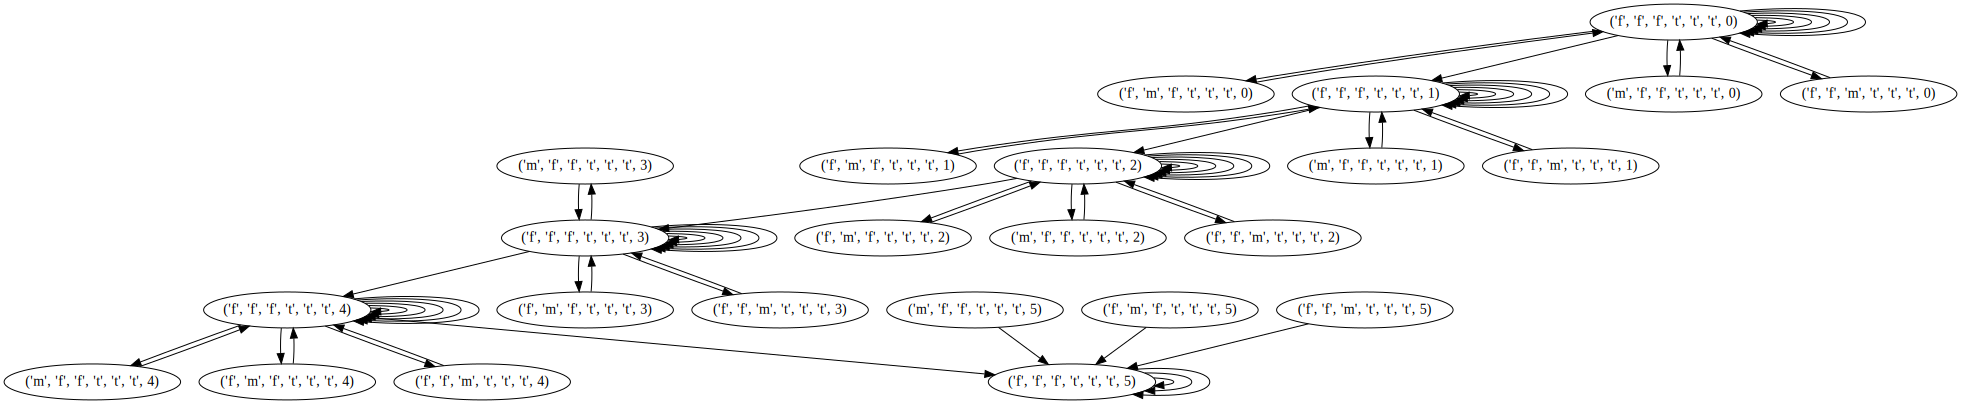

In [22]:
from pkg.utils.graph_visualize import *

vg = VisualGraph()

def simplify_node(node):
    return tuple([ntem[0] if isinstance(ntem, str) else ntem for ntem in node])

for node, leafs in inc.node_dict.items():
    vg.add_node(simplify_node(node), [simplify_node(leaf) for leaf in leafs])
    
gv = vg.draw()
# gv.save()
gv